### Get Data

In [1]:
# pip install psycopg2
#!pip install snowflake

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from datetime import datetime
import requests
from datetime import date
from datetime import timedelta
import snowflake.connector

In [2]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='SPARK',
    authenticator = "externalbrowser",
    account='BROOKLYNSPORTSANDENTERTAINMENT-BSEGLOBAL',  # e.g., xy12345.us-east-1
    warehouse='All Too Ware',
    database='BSEDW',
    schema='WAITTIME', 
    role = "SNOWFLAKE_DOMINATEAI"
)
cursor = conn.cursor()
# Explicitly activate the warehouse
cursor.execute('USE WAREHOUSE "All Too Ware"')

# Query data
query = "SELECT * FROM WAITTIME_STATSACTUALVIEW where EVENT_DATE <= '2025-07-27'"
cursor.execute(query)

# Convert to pandas DataFrame
df = cursor.fetch_pandas_all()

# Close the connection
cursor.close()
conn.close()

# Display results
print(df.head())


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://bseglobal.okta.com/app/snowflake/exkqh96ogn06lUM3g4x7/sso/saml?SAMLRequest=rZNbb%2BIwEIX%2FSuR9JjaUqwVUbBEqEmwRl1WVNycxwcLxpB6ngf31a0JB3Yf2ad8s%2B5yZz3Ps4eMp18G7tKjAjEgzZCSQJoFUmWxEdttZo08CdMKkQoORI3KWSB7HQxS5LvikdAezlm%2BlRBf4QgZ5fTAipTUcBCrkRuQSuUv4ZrJc8FbIeGHBQQKafLJ87xCI0jpPeLOkqDzewbmCU1pVVVg9hGAz2mKMUTagXnWR%2FLjpT%2F5OX%2BiblLUveq%2Fw8tUH209lriP4Diu%2BipA%2Fb7erxuplsyXB5Ib6BAbLXNqNtO8qkbv14gqAniC2AEd9NliAdeiHK43zLqFM7leNGGWmIRY6RAPVXoujTCAvSuebhX5F9zKlGjLl5zGfjkhxVOlrbMtooOBludjafjyLX6NF1GPHvP0nXeyyCNfPPYCujjqThAS%2Fb4G3LoHPEUs5N5eYnd9irU6D9RusvW0OeLvFGQv7vU5EgqmPWRnhauf9LndYODpR44mioHdyKk%2FHt8OgC5lhXb1bPmTtU48iAr3kTq5PidcIdvyfBjSkn4t%2BPNZfPr%2F5dAVaJedgBjYX7ut4m2Gz3lFpY19LucyF0pM0tRLRx6w1VE9WCuf%2FhLOlJHR87frvrxj%2FBQ%3D%3D

In [3]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()

In [ ]:
needed_columns = ['event_name',
'event_name_long',
'event_date',
'event_time',
'event_day',
'starttime',
'team',
'minor_category',
'property',
'numberinline',
'relative start (minutes)',
'wait time (minutes)',
'time category']

df = df[needed_columns]

In [5]:
# CSV
df.to_csv('wait time.csv', index=False)  

In [6]:
# Convert times 
df['event_date'] = pd.to_datetime(df['event_date'])
df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
df['event_time'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.time

# Note: relative start (minutes) should already be calculated in the source data
# If it's missing, we would need the actual timestamp column to compute it

In [7]:
# Remove upsell or irrelevant events
df = df[~(df['event_name_long'].str.contains("Upsell", na=False) | 
          df['event_name_long'].str.contains("CANCELED", na=False) |
          df['event_name_long'].str.contains("Cancelled", na=False) |
          df['event_name_long'].str.contains("Test", na=False))]

# Drop nulls in critical columns
df = df.dropna(subset=['relative start (minutes)', 'wait time (minutes)', 'numberinline'])

### When to cutoff relative start time

In [8]:
# Print minimum and maximum event_date
print('Minimum event_date:', df['event_date'].min())
print('Maximum event_date:', df['event_date'].max())

Minimum event_date: 2023-09-01 00:00:00
Maximum event_date: 2025-07-26 00:00:00


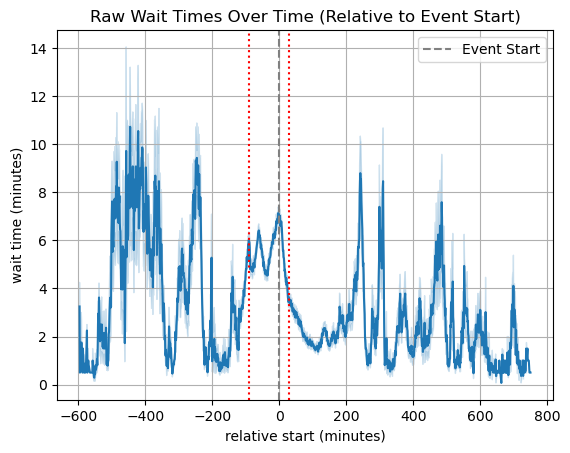

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x='relative start (minutes)', y='wait time (minutes)')
plt.title("Raw Wait Times Over Time (Relative to Event Start)")
plt.axvline(0, linestyle='--', color='gray', label='Event Start')
plt.axvline(-90, linestyle=':', color='red')
plt.axvline(30, linestyle=':', color='red')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Round to nearest minute
df['relative start (minutes)'].astype(int) 

# Filter out after-event tail if not useful
df = df[df['relative start (minutes)'] <= 30] # Operataional cutoff 
df = df[df['relative start (minutes)'] >= -90]

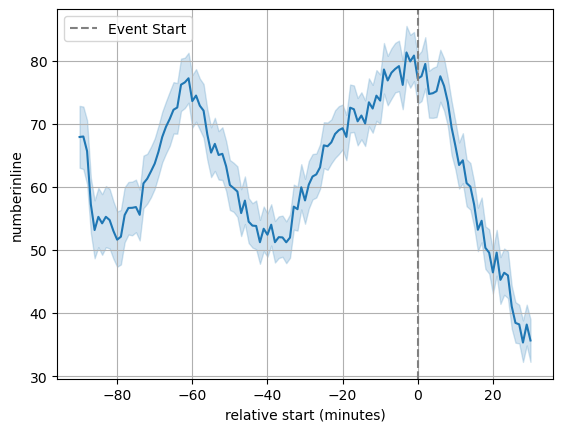

In [11]:
sns.lineplot(data=df, x='relative start (minutes)', y='numberinline')
plt.axvline(0, linestyle='--', color='gray', label='Event Start')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 5 minute buckets 
df['5_minute_bucket'] = (df['relative start (minutes)'] // 5) * 5

### Queue trend with numberline

In [13]:
# Adding queue trend features (when lines are accelearating or decelerating)
df = df.sort_values(['event_name','relative start (minutes)'])

# 5-minute rolling mean -- congestion at specific times 
df['queue_mean_5'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=5, min_periods=1).mean())
)
df['day_of_week'] = df['event_date'].dt.dayofweek
# 5-minute rolling slope (simple linear trend) -- accelration or deceleration of queue
def _slope(a):
    idx = np.arange(len(a))
    return np.polyfit(idx, a, 1)[0]  # coefficient of x

df['queue_slope_5'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=5, min_periods=2).apply(_slope, raw=True))
      .fillna(0)
)


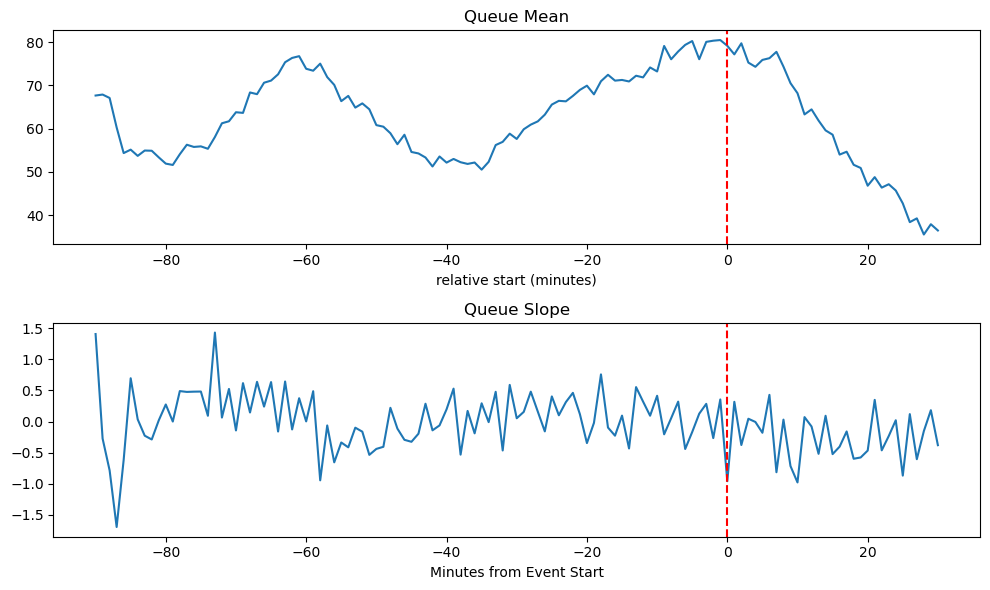

In [14]:
# Combined plot
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
df.groupby('relative start (minutes)')['queue_mean_5'].mean().plot()
plt.title('Queue Mean')
plt.axvline(0, color='red', linestyle='--')

plt.subplot(2,1,2)
df.groupby('relative start (minutes)')['queue_slope_5'].mean().plot()
plt.title('Queue Slope')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Minutes from Event Start')

plt.tight_layout()
plt.show()

### Cyclical

In [15]:
# Add cyclical time features for better modeling
df['hour'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of week cyclical encoding
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Minute bucket cyclical encoding (for within-event timing)
df['minute_sin'] = np.sin(2 * np.pi * df['relative start (minutes)'] / 30)  # 30 minute cycle
df['minute_cos'] = np.cos(2 * np.pi * df['relative start (minutes)'] / 30)

### Attendance 

In [16]:
# Attendence counts 
def run_query():
#Connect with the database
    DW_HOST = "172.22.12.130"
    DW_PORT = "5432"
    DW_USER = "spark"
    DW_PASS = "Brooklyn_2025!"
    DW_BSEDW_DATABASE = "bsedw"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
 SELECT event_date, event_time, count (*)
        FROM archtics_new.v_attendance_scans vas
        WHERE 
            result_code_desc = 'Initial Entry'
        group by 1, 2
    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
attendance = run_query()
print(attendance)

C:\Users\spark\AppData\Local\Temp\ipykernel_8956\2998683415.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql(query, con = connection)


    event_date event_time  count
0   2023-03-13   20:00:00      5
1   2023-03-17   17:30:00   3131
2   2023-04-01   20:00:00  10986
3   2023-05-05   19:00:00   5158
4   2023-05-06   11:00:00    309
..         ...        ...    ...
467 2025-07-22   20:00:00  15010
468 2025-07-25   19:30:00  15518
469 2025-07-26   19:00:00  14200
470 2025-07-29   19:30:00  15537
471 2025-07-31   20:00:00   9553

[472 rows x 3 columns]


In [17]:
# Fix attendance data formatting for successful merge
attendance['event_date'] = pd.to_datetime(attendance['event_date'])
# Convert attendance event_time from string to time object (key fix!)
if isinstance(attendance['event_time'].iloc[0], str):
    attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time
elif isinstance(attendance['event_time'].iloc[0], pd.Timestamp):
    attendance['event_time'] = attendance['event_time'].dt.time

# Now perform the merges properly with fixed formatting
print("\n=== Merging with attendance data ===")
df_merged = pd.merge(df, attendance, on=['event_date', 'event_time'], how='left', suffixes=('', '_attendance'))
attendance_matches = df_merged['count'].notna().sum()
print(f"After attendance merge shape: {df_merged.shape}")
print(f"Attendance matches: {attendance_matches} out of {len(df_merged)} records ({attendance_matches/len(df_merged)*100:.1f}%)")
print("After attendance merge columns:", df_merged.columns.tolist())

# Update the main df variable
df = df_merged.copy()

print("\n=== Final df summary ===")
print("Final df shape:", df.shape)
print("Final df columns:", df.columns.tolist())
print(f"Records with both attendance and category data: {((df['count'].notna()) & (df['minor_category'].notna())).sum()}")
print("\nSample of final df:")
print(df[['event_date', 'event_time', 'event_day', 'count']].head())


=== Merging with attendance data ===
After attendance merge shape: (202596, 26)
Attendance matches: 202047 out of 202596 records (99.7%)
After attendance merge columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'event_type', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', '5_minute_bucket', 'queue_mean_5', 'day_of_week', 'queue_slope_5', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'count']

=== Final df summary ===
Final df shape: (202596, 26)
Final df columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'event_type', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', '5_minute_bucket', 'queue_mean_5', 'day_of_week', 'queue_slope_5', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'c

C:\Users\spark\AppData\Local\Temp\ipykernel_8956\2759237163.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time


In [18]:
# Check rows with NaN count values
nan_count_rows = df[df['count'].isna()]

print(f"Number of rows with NaN count: {len(nan_count_rows)}")
print(f"Percentage of rows with NaN count: {len(nan_count_rows)/len(df)*100:.1f}%")

Number of rows with NaN count: 549
Percentage of rows with NaN count: 0.3%


### Tiers

In [19]:
def run_query():
#Connect with the database
    DW_HOST = "172.22.12.130"
    DW_PORT = "5432"
    DW_USER = "spark"
    DW_PASS = "Brooklyn_2025!"
    DW_BSEDW_DATABASE = "bsedw"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
select event_date, tier::text
from bi.liberty_season_23 ls 

union all 

select "Date"::date as event_date, "Individual Tier"::text  as tier
from bi.liberty_season_24 ls 

union all 

select event_date, "start_of_season_individual_tier" as tier
from bi.liberty_season_25 ls

union all

select event_date, tier::text
from bi.nets_season_22 ns

union all

select event_date, tier::text
from bi.nets_season_23 ns

union all

select event_date, tier::text
from bi.nets_season_24 ns


    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
tiers = run_query()
print(tiers)

C:\Users\spark\AppData\Local\Temp\ipykernel_8956\4197084525.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql(query, con = connection)


     event_date tier
0    2023-05-21    1
1    2023-05-27    2
2    2023-06-04    2
3    2023-06-07    3
4    2023-06-11    2
..          ...  ...
188  2025-04-03    4
189  2025-04-06    5
190  2025-04-08    6
191  2025-04-10    6
192  2025-04-13    2

[193 rows x 2 columns]


In [20]:
# Convert event_date to datetime
tiers['event_date'] = pd.to_datetime(tiers['event_date'])

In [21]:
# Clean tier values - convert "+1" to "1" and ensure only numeric values
tiers['tier'] = tiers['tier'].astype(str).str.replace('+', '', regex=False)
tiers['tier'] = tiers['tier'].str.extract('(\d+)')[0]  # Extract only numeric part
print("Unique tier values after cleaning:", sorted(tiers['tier'].unique()))

Unique tier values after cleaning: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\spark\AppData\Local\Temp\ipykernel_8956\1622986667.py:3: SyntaxWarning: invalid escape sequence '\d'
  tiers['tier'] = tiers['tier'].str.extract('(\d+)')[0]  # Extract only numeric part


In [22]:
# Save to CSV
tiers.to_csv('tiers.csv', index=False) 

In [23]:
tiers['tier'].unique()

array(['1', '2', '3', '4', '6', '7', '5', '0', '8'], dtype=object)

Merging Tiers and DF

In [24]:
# Filter tiers to match only event_dates in df
tiers_filtered = tiers[tiers['event_date'].isin(df['event_date'].unique())]

# Merge with df (now only dates that exist in df will be merged in)
df_with_tiers = df.merge(tiers_filtered, on='event_date', how='left')

In [25]:
# Check if merge worked 
df_liberty = df_with_tiers[df_with_tiers["property"] == "Liberty"]
df_liberty_check = df_liberty[['event_name_long', 'event_date', 'team', 'tier']].drop_duplicates().sort_values('event_date')
print(df_liberty_check.head())

                                event_name_long event_date  \
78401      New York Liberty vs. Connecticut Sun 2023-09-01   
79198   New York Liberty vs. Washington Mystics 2023-09-10   
200797         Libs for Kids 2023 Holding Event 2023-12-31   
175082       New York Liberty vs. Indiana Fever 2024-05-18   
176161       New York Liberty vs. Seattle Storm 2024-05-20   

                             team tier  
78401   Connecticut Sun              2  
79198   Washington Mystics           1  
200797  Libs for Kids              NaN  
175082  Indiana Fever                1  
176161  Seattle Storm                4  


Fill in missing tier rows with average of tiers for the teams they played historically

In [26]:
# Handle missing tiers
# Check how many events are missing tier information
missing_tiers = df_with_tiers['tier'].isna().sum()
total_rows = len(df_with_tiers)
print(f"Missing tiers: {missing_tiers} out of {total_rows} rows ({missing_tiers/total_rows*100:.1f}%)")

Missing tiers: 122951 out of 202596 rows (60.7%)


In [27]:
# Analyze missing tier values by property
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays                0         119747                 inf
Brooklyn Nets       59409           2557                 4.3
Liberty             20236            647                 3.2


In [28]:
# Extract known tiers only
known_tiers = df_with_tiers[
    df_with_tiers['property'].isin(['Liberty', 'Brooklyn Nets']) & df_with_tiers['tier'].notna()
]

# You may need to extract team if not already done
# Assuming event_name format: "NY Liberty vs Las Vegas Aces"
def extract_team(team):
    if pd.isna(team):
        return None
    return str(team).strip()

# Update team column if it exists, otherwise create it
if 'team' in df_with_tiers.columns:
    df_with_tiers['team'] = df_with_tiers['team'].apply(extract_team)
else:
    df_with_tiers['team'] = df_with_tiers['event_name'].apply(lambda x: x.split('vs')[-1].strip() if 'vs' in x else None)

In [29]:
# Create mapping from (property, team) -> average tier
# First convert tier to numeric for averaging
known_tiers_numeric = known_tiers.copy()
known_tiers_numeric['tier_numeric'] = pd.to_numeric(known_tiers_numeric['tier'], errors='coerce')

tier_lookup = (
    known_tiers_numeric.groupby(['property', 'team'])['tier_numeric']
    .mean()  # average tier per matchup 
    .round()  # round to nearest whole tier
    .astype(str)  # convert back to string to match original tier format
    .reset_index()
    .rename(columns={'tier_numeric': 'tier'})
)

In [30]:
# Clean and standardize team names in both dataframes
df_with_tiers['team'] = df_with_tiers['team'].str.strip().str.lower()
tier_lookup['team'] = tier_lookup['team'].str.strip().str.lower()


In [31]:
# Merge back to assign estimated tiers to missing
df_with_missing_tiers = df_with_tiers[df_with_tiers['tier'].isna()]
df_with_missing_tiers = df_with_missing_tiers.merge(
    tier_lookup,
    on=['property', 'team'],
    how='left',
    suffixes=('', '_estimated')
)

# Fill in missing values
df_with_tiers.loc[df_with_tiers['tier'].isna(), 'tier'] = df_with_missing_tiers['tier_estimated'].values

In [32]:
# Check if the Nets and Liberty rows are all filed 
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays                0         119747                 inf
Liberty             20334            549                 2.7
Brooklyn Nets       60716           1250                 2.1


Missing tiers for all Barclays Events

Checking correlation between attendance count and tier 

In [33]:
# Calculate correlation between all numeric features and tier for each property
import warnings
warnings.filterwarnings('ignore')

# Convert tier to numeric for correlation analysis
df_corr = df_with_tiers.copy()
df_corr['tier_numeric'] = pd.to_numeric(df_corr['tier'].str.replace('T', ''), errors='coerce')

# Select numeric columns for correlation analysis
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
# Remove tier_numeric from the list to avoid self-correlation
if 'tier_numeric' in numeric_cols:
    numeric_cols.remove('tier_numeric')

print("=== CORRELATION ANALYSIS: Tier vs Features by Property ===\n")

for prop in ['Liberty', 'Brooklyn Nets']:
    prop_data = df_corr[df_corr['property'] == prop]
    
    if len(prop_data) == 0:
        continue
        
    print(f"--- {prop} ---")
    
    # Calculate correlations with tier
    correlations = []
    for col in numeric_cols:
        if col in prop_data.columns and prop_data[col].notna().sum() > 0:
            corr = prop_data[col].corr(prop_data['tier_numeric'])
            if not pd.isna(corr):
                correlations.append((col, corr))
    
    # Sort by absolute correlation value
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Top correlations with tier:")
    for col, corr in correlations[:10]:  # Show top 10
        print(f"  {col:25s}: {corr:6.3f}")
    
    print()

=== CORRELATION ANALYSIS: Tier vs Features by Property ===

--- Liberty ---
Top correlations with tier:
  day_of_week              : -0.524
  day_sin                  :  0.485
  hour_sin                 : -0.366
  hour                     :  0.357
  hour_cos                 :  0.350
  count                    : -0.207
  day_cos                  : -0.128
  wait time (minutes)      : -0.075
  queue_mean_5             : -0.029
  numberinline             : -0.023

--- Brooklyn Nets ---
Top correlations with tier:
  count                    : -0.587
  queue_mean_5             : -0.131
  hour_sin                 :  0.125
  wait time (minutes)      : -0.122
  day_cos                  : -0.121
  hour                     : -0.119
  hour_cos                 : -0.116
  numberinline             : -0.089
  5_minute_bucket          :  0.022
  relative start (minutes) :  0.022



In [34]:

# Also show overall correlations (all properties combined)
print("--- ALL PROPERTIES COMBINED ---")
correlations_all = []
for col in numeric_cols:
    if col in df_corr.columns and df_corr[col].notna().sum() > 0:
        corr = df_corr[col].corr(df_corr['tier_numeric'])
        if not pd.isna(corr):
            correlations_all.append((col, corr))

correlations_all.sort(key=lambda x: abs(x[1]), reverse=True)

print("Top correlations with tier (all properties):")
for col, corr in correlations_all[:10]:
    print(f"  {col:25s}: {corr:6.3f}")

--- ALL PROPERTIES COMBINED ---
Top correlations with tier (all properties):
  hour_sin                 : -0.178
  day_of_week              : -0.160
  count                    : -0.137
  hour                     :  0.124
  queue_mean_5             : -0.117
  hour_cos                 :  0.110
  wait time (minutes)      : -0.109
  day_sin                  :  0.107
  numberinline             : -0.084
  day_cos                  : -0.073


Using attendence to create tiers for Barlcays as placeholder

In [35]:
# Step 1: Filter Barclays events with attendance data
barclays_attendance = df_with_tiers[
    (df_with_tiers['property'] == 'Barclays') & 
    (df_with_tiers['count'].notna())
]

# Step 2: Use qcut to generate 8-tier bins
barclays_attendance['tier_numeric'] = pd.qcut(
    barclays_attendance['count'], 
    q=8, 
    labels=[str(i) for i in range(8, 0, -1)]  # Tier 8 = highest attendance, Tier 1 = lowest
)

# Step 3: Build lookup table for event_date → estimated tier
attendance_tier_map = barclays_attendance[['event_date', 'tier_numeric']].drop_duplicates()

# Step 4: Merge into df_with_tiers to assign estimated tier
df_with_tiers = df_with_tiers.merge(
    attendance_tier_map,
    on='event_date',
    how='left',
    suffixes=('', '_estimated')
)

# Step 5: Fill only missing Barclays tiers with the estimated ones
mask = (df_with_tiers['property'] == 'Barclays') & (df_with_tiers['tier'].isna())
df_with_tiers.loc[mask, 'tier'] = df_with_tiers.loc[mask, 'tier_numeric']

# Drop temporary column
df_with_tiers.drop(columns=['tier_numeric'], inplace=True)


In [36]:
df_with_tiers['tier'] = df_with_tiers['tier'].astype(float)

### Weather

Historical

In [37]:
# Define parameters for historical weather data
latitude = 40.684908   # Barclays Center
longitude = -73.977862
start_date = str(df_with_tiers['event_date'].min().date())
end_date = '2025-07-27' #str(df_with_tiers['event_date'].max().date())

# API Endpoint
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto"

# Make request
response = requests.get(url)
data = response.json()

# Convert to DataFrame
weather = pd.DataFrame(data["daily"])
weather["time"] = pd.to_datetime(weather["time"])  # Convert time to datetime format

weather = weather.rename(columns={'time': 'event_date'})

In [38]:
weather

,event_date,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2023-09-01,23.9,13.6,0.0
1,2023-09-02,24.7,12.5,0.0
2,2023-09-03,32.4,18.4,0.3
3,2023-09-04,34.0,20.2,5.4
4,2023-09-05,34.5,22.1,0.0
...,...,...,...,...
691,2025-07-23,27.0,20.3,0.0
692,2025-07-24,28.9,20.6,0.0
693,2025-07-25,37.3,24.4,3.2
694,2025-07-26,28.4,23.6,0.0


In [39]:
df_with_weather = df_with_tiers.merge(weather, on = 'event_date', how = 'left')

In [40]:
df_with_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215787 entries, 0 to 215786
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   event_name                215787 non-null  object        
 1   event_name_long           215787 non-null  object        
 2   event_date                215787 non-null  datetime64[ns]
 3   event_time                215787 non-null  object        
 4   event_day                 215787 non-null  object        
 5   starttime                 215787 non-null  datetime64[ns]
 6   team                      215787 non-null  object        
 7   event_type                215787 non-null  object        
 8   minor_category            215787 non-null  object        
 9   property                  215787 non-null  object        
 10  numberinline              215787 non-null  int16         
 11  relative start (minutes)  215787 non-null  int64         
 12  wa

In [41]:
df_with_weather.to_csv('df_with_weather.csv', index=False)

### More Features

In [43]:
# Interaction features
df_with_weather['minute_minor_interaction'] = df_with_weather['relative start (minutes)'] * df_with_weather['minor_category'].astype('category').cat.codes
df_with_weather['minute_sq'] = df_with_weather['relative start (minutes)']**2
df_with_weather['property_minor_interaction'] = df_with_weather['property'].astype('category').cat.codes * df_with_weather['minor_category'].astype('category').cat.codes


### Modeling

In [ ]:
features = [
    'event_name',
    'relative start (minutes)',
    'event_day', # need one hot 
    'team', # need one hot 
    'minor_category', # need one hot
    'property', # need one hot
    'time category', # need one hot
    '5_minute_bucket',
    'queue_mean_5', 
    'queue_slope_5',
    'hour',
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos',
    'minute_sin',
    'minute_cos',
    'count',
    'tier', 
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'minute_minor_interaction',
    'minute_sq',
    'property_minor_interaction']
target = 'wait time (minutes)'

In [58]:
class WaitTimeQuantileRegressor:
    def __init__(self, quantiles=[0.95]):
        """
        Event-specific quantile wait time predictor for operational planning.
        
        This model predicts specific quantiles (default: 95th percentile) of wait time 
        for each event at each time bucket, using proper preprocessing pipeline.
        
        Args:
            quantiles: List of quantiles to predict (default: [0.95] for 95th percentile)
        """
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        
        self.quantiles = quantiles
        self.models = {}
        self.preprocessor = None
        self.features = []
        
        # Define categorical and numerical features
        self.categorical_features = [col for col in features if df_with_weather[col].dtype == 'object']
        self.numerical_features = [col for col in features if col not in self.categorical_features]
        
    def _prepare_data(self, df_with_weather, features):
        """Prepare data with proper tier conversion and feature selection."""
        import pandas as pd
        import numpy as np
        
        df_model = df_with_weather.copy()
        self.features = features
        
        # Debug: Check for missing values in key columns
        print("=== DATA PREPARATION DEBUG ===")
        missing_data = df_model[features].isnull().sum()
        missing_cols = missing_data[missing_data > 0]
        if len(missing_cols) > 0:
            print("Columns with missing values:")
            for col, count in missing_cols.items():
                pct = (count / len(df_model)) * 100
                print(f"  {col}: {count} missing ({pct:.1f}%)")
        else:
            print("✅ No missing values in feature columns")
            
        return df_model
        
    def fit(self, df_with_weather, features, target):
        """
        Train the event-specific quantile model WITHOUT NaN handling to debug issues.
        """
        from sklearn.linear_model import QuantileRegressor
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        import numpy as np
        import pandas as pd
        
        # Prepare the data
        df_model = self._prepare_data(df_with_weather, features)
        
        # Prepare features and target
        X = df_model[features].copy()
        y = df_model[target]
        
        # Remove rows where target is NaN
        valid_mask = ~y.isnull()
        X = X[valid_mask]
        y = y[valid_mask]
        df_model = df_model[valid_mask]
        
        print(f"After removing missing targets: {len(X)} samples")
        
        # Automatically detect categorical and numerical features from available columns
        available_categorical = [col for col in self.categorical_features if col in X.columns]
        available_numerical = [col for col in self.numerical_features if col in X.columns]
        
        print(f"Categorical features: {available_categorical}")
        print(f"Numerical features: {available_numerical}")
        
        # Create BASIC preprocessing pipeline WITHOUT imputation to see raw NaN issues
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), available_numerical),
                ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), available_categorical)
            ],
            remainder='drop'
        )
        
        # Train/test split by events (not random rows)
        events = df_model['event_name'].unique()
        np.random.seed(42)
        train_events = np.random.choice(events, size=int(0.8 * len(events)), replace=False)
        
        train_mask = df_model['event_name'].isin(train_events)
        X_train = X[train_mask]
        X_test = X[~train_mask]
        y_train = y[train_mask]
        y_test = y[~train_mask]
        
        print(f"Training on {len(train_events)} events ({len(X_train)} data points)")
        print(f"Testing on {len(events) - len(train_events)} events ({len(X_test)} data points)")
        

        
        # Try to fit preprocessor and see what happens
        print("\n=== PREPROCESSOR FITTING ===")
        try:
            X_train_processed = self.preprocessor.fit_transform(X_train)
            X_test_processed = self.preprocessor.transform(X_test)
            
            print(f"✅ Preprocessing successful!")
            print(f"X_train_processed shape: {X_train_processed.shape}")
            print(f"X_test_processed shape: {X_test_processed.shape}")
            
            # Check for NaN in processed data
            if hasattr(X_train_processed, 'toarray'):  # Sparse matrix
                train_nan_count = np.isnan(X_train_processed.toarray()).sum()
                test_nan_count = np.isnan(X_test_processed.toarray()).sum()
                print(f"Processed data is sparse matrix")
                if train_nan_count > 0:
                    print(f"⚠️  {train_nan_count} NaN values in processed training data")
                    nan_locations = np.where(np.isnan(X_train_processed.toarray()))
                    print(f"   NaN locations (first 10): {list(zip(nan_locations[0][:10], nan_locations[1][:10]))}")
                if test_nan_count > 0:
                    print(f"⚠️  {test_nan_count} NaN values in processed test data")
            else:  # Dense array
                train_nan_count = np.isnan(X_train_processed).sum()
                test_nan_count = np.isnan(X_test_processed).sum()
                print(f"Processed data is dense matrix")
                if train_nan_count > 0:
                    print(f"⚠️  {train_nan_count} NaN values in processed training data")
                    nan_locations = np.where(np.isnan(X_train_processed))
                    print(f"   NaN locations (first 10): {list(zip(nan_locations[0][:10], nan_locations[1][:10]))}")
                if test_nan_count > 0:
                    print(f"⚠️  {test_nan_count} NaN values in processed test data")
            
            if train_nan_count == 0 and test_nan_count == 0:
                print("✅ No NaN values in processed data - proceeding with model training")
                
                # Train models for each quantile
                for quantile in self.quantiles:
                    print(f"\nTraining Event-Specific {quantile*100:.0f}th Percentile Model...")
                    
                    # Use QuantileRegressor for proper quantile prediction
                    model = QuantileRegressor(
                        quantile=quantile,
                        alpha=0.01,  # L1 regularization for robustness
                        solver='highs',
                        fit_intercept=True
                    )
                    
                    model.fit(X_train_processed, y_train)
                    self.models[quantile] = model
                    
                    # Evaluate model
                    y_pred = model.predict(X_test_processed)
                    
                    # Debug: Check prediction distribution
                    print(f"   Prediction stats: min={y_pred.min():.2f}, max={y_pred.max():.2f}, mean={y_pred.mean():.2f}, std={y_pred.std():.2f}")
                    print(f"   Actual stats: min={y_test.min():.2f}, max={y_test.max():.2f}, mean={y_test.mean():.2f}, std={y_test.std():.2f}")
                    
                    # Calculate metrics
                    mae = mean_absolute_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    coverage = np.mean(y_test <= y_pred)
                    buffer = y_pred - y_test
                    avg_buffer = np.mean(buffer)
                    over_prediction_rate = np.mean(buffer > 0)
                    
                    print(f"   MAE: {mae:.2f} minutes")
                    print(f"   RMSE: {rmse:.2f} minutes")
                    print(f"   Coverage: {coverage:.2f} (Target: {quantile:.2f})")
                    print(f"   Average Buffer: {avg_buffer:.2f} minutes")
                    print(f"   Over-prediction Rate: {over_prediction_rate:.2f}")
            else:
                print("⚠️  Cannot train model with NaN values in processed data!")
                return None
                
        except Exception as e:
            print(f"❌ Preprocessing failed: {e}")
            return None
        
        # Store results for the primary quantile
        primary_quantile = self.quantiles[0]
        y_pred_primary = self.models[primary_quantile].predict(X_test_processed)
        mae = mean_absolute_error(y_test, y_pred_primary)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_primary))
        coverage = np.mean(y_test <= y_pred_primary)
        avg_buffer = np.mean(y_pred_primary - y_test)
        over_prediction_rate = np.mean((y_pred_primary - y_test) > 0)
        
        self.results = {
            'MAE': mae, 
            'RMSE': rmse, 
            'Coverage': coverage, 
            'Average_Buffer': avg_buffer,
            'Over_Prediction_Rate': over_prediction_rate
        }
        
        # Store test data for plotting
        self._X_test = X_test
        self._y_test = y_test
        
        return self.results
    
    def predict(self, X):
        """
        Predict wait times for all quantiles
        """
        if self.preprocessor is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        # Ensure X has the same feature columns
        X_pred = X[self.features].copy()
        
        # Transform features using the fitted preprocessor
        X_processed = self.preprocessor.transform(X_pred)
        
        # Make predictions for each quantile
        predictions = {}
        for quantile in self.quantiles:
            predictions[quantile] = self.models[quantile].predict(X_processed)
        
        # Return single array if only one quantile, otherwise return dictionary
        if len(self.quantiles) == 1:
            return predictions[self.quantiles[0]]
        else:
            return predictions
    
    def plot_model_performance(self, df_with_weather, target, sample_size=1000):
        """
        Plot model performance for evaluation.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        if self.preprocessor is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        # Use stored test data for plotting
        X_test = self._X_test
        y_test = self._y_test
        
        # Sample for plotting if dataset is large
        if len(X_test) > sample_size:
            idx = np.random.choice(len(X_test), sample_size, replace=False)
            X_plot = X_test.iloc[idx]
            y_plot = y_test.iloc[idx]
        else:
            X_plot = X_test
            y_plot = y_test
        
        # Make predictions
        X_processed = self.preprocessor.transform(X_plot)
        primary_quantile = self.quantiles[0]
        y_pred = self.models[primary_quantile].predict(X_processed)
        buffer = y_pred - y_plot
        
        # Create plots
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Predictions vs Actual
        plt.subplot(1, 3, 1)
        plt.scatter(y_plot, y_pred, alpha=0.6, s=20)
        plt.plot([y_plot.min(), y_plot.max()], [y_plot.min(), y_plot.max()], 'r--', label='Perfect Prediction')
        plt.xlabel('Actual Wait Time (minutes)')
        plt.ylabel(f'{primary_quantile*100:.0f}th Percentile Prediction (minutes)')
        plt.title(f'Event-Specific {primary_quantile*100:.0f}th Percentile Predictions')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Buffer Distribution
        plt.subplot(1, 3, 2)
        plt.hist(buffer, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', label='No Buffer')
        plt.axvline(x=np.mean(buffer), color='orange', linestyle='--', 
                   label=f'Avg Buffer: {np.mean(buffer):.2f}min')
        plt.xlabel('Buffer (Predicted - Actual)')
        plt.ylabel('Frequency')
        plt.title('Operational Buffer Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Coverage Rate
        plt.subplot(1, 3, 3)
        coverage = np.mean(y_plot <= y_pred)
        plt.bar(['Coverage'], [coverage], color='skyblue', alpha=0.7)
        plt.axhline(y=primary_quantile, color='red', linestyle='--', 
                   label=f'Target {primary_quantile*100:.0f}%')
        plt.ylabel('Coverage Rate')
        plt.title(f'Coverage: {coverage:.2f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

In [59]:
# Train the Event-Specific 95th Percentile Model
print("=" * 60)
print("EVENT-SPECIFIC 95TH PERCENTILE WAIT TIME PREDICTOR")
print("=" * 60)

# Initialize and train the model
wait_time_model = WaitTimeQuantileRegressor()
results = wait_time_model.fit(df_with_weather, features, target)

# Plot model performance
wait_time_model.plot_model_performance(df_with_weather, target)

EVENT-SPECIFIC 95TH PERCENTILE WAIT TIME PREDICTOR
=== DATA PREPARATION DEBUG ===
Columns with missing values:
  count: 549 missing (0.3%)
  tier: 1799 missing (0.8%)
After removing missing targets: 215787 samples
Categorical features: ['event_name', 'event_day', 'team', 'event_type', 'minor_category', 'property', 'time category']
Numerical features: ['relative start (minutes)', '5_minute_bucket', 'queue_mean_5', 'queue_slope_5', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'count', 'tier', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'minute_minor_interaction', 'minute_sq', 'property_minor_interaction']
Training on 252 events (167360 data points)
Testing on 63 events (48427 data points)

=== PREPROCESSOR FITTING ===
✅ Preprocessing successful!
X_train_processed shape: (167360, 459)
X_test_processed shape: (48427, 459)
Processed data is sparse matrix
⚠️  2348 NaN values in processed test data
⚠️  Cannot train model with NaN value

AttributeError: 'WaitTimeQuantileRegressor' object has no attribute '_X_test'

In [ ]:
# Use GradientBoostingRegressor with quantile loss
# This can learn complex feature interactions that QuantileRegressor cannot

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

print("=" * 80)
print("GRADIENT BOOSTING WITH QUANTILE LOSS")
print("=" * 80)

# Prepare the same data
df_model = wait_time_model._prepare_data(df_with_weather, features)
X = df_model[wait_time_model.features].copy()
y = df_model[target]

# Remove rows where target is NaN
valid_mask = ~y.isnull()
X = X[valid_mask]
y = y[valid_mask]
df_model = df_model[valid_mask]

# Same train/test split by events
events = df_model['event_name'].unique()
np.random.seed(42)
train_events = np.random.choice(events, size=int(0.8 * len(events)), replace=False)

train_mask = df_model['event_name'].isin(train_events)
X_train = X[train_mask]
X_test = X[~train_mask]
y_train = y[train_mask]
y_test = y[~train_mask]

# Use the same preprocessor
X_train_processed = wait_time_model.preprocessor.transform(X_train)
X_test_processed = wait_time_model.preprocessor.transform(X_test)

# Train GradientBoostingRegressor with quantile loss
print("Training GradientBoosting with 95th percentile quantile loss...")
gb_quantile_model = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.95,  # 95th percentile
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

gb_quantile_model.fit(X_train_processed, y_train)

# Make predictions
y_pred_gb = gb_quantile_model.predict(X_test_processed)

# Check if this model learns patterns
print(f"\nGradient Boosting Results:")
print(f"Prediction variance: {y_pred_gb.var():.6f}")
print(f"Prediction range: {y_pred_gb.min():.2f} to {y_pred_gb.max():.2f} minutes")
print(f"Are all predictions identical? {len(set(np.round(y_pred_gb, 2))) == 1}")

# Sample predictions
print(f"\nSample predictions from Gradient Boosting:")
for i in range(min(10, len(y_test))):
    print(f"Row {i:2d}: Actual={y_test.iloc[i]:6.2f}min, GB_Pred={y_pred_gb[i]:6.2f}min, QR_Pred={13.19:6.2f}min")

# Calculate metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
coverage_gb = np.mean(y_test <= y_pred_gb)
buffer_gb = np.mean(y_pred_gb - y_test)

print(f"\nGradient Boosting Performance:")
print(f"MAE: {mae_gb:.2f} minutes")
print(f"RMSE: {rmse_gb:.2f} minutes") 
print(f"Coverage: {coverage_gb:.2f} (Target: 0.95)")
print(f"Average Buffer: {buffer_gb:.2f} minutes")

# Compare with QuantileRegressor
y_pred_qr = np.full_like(y_pred_gb, 13.19)  # Constant prediction
mae_qr = mean_absolute_error(y_test, y_pred_qr)
coverage_qr = np.mean(y_test <= y_pred_qr)
buffer_qr = np.mean(y_pred_qr - y_test)

print(f"\nQuantileRegressor Performance (for comparison):")
print(f"MAE: {mae_qr:.2f} minutes")
print(f"Coverage: {coverage_qr:.2f}")
print(f"Average Buffer: {buffer_qr:.2f} minutes")

print("\n" + "="*80)

GRADIENT BOOSTING WITH QUANTILE LOSS
=== DATA PREPARATION DEBUG ===
✅ No missing values in feature columns
Training GradientBoosting with 95th percentile quantile loss...

Gradient Boosting Results:
Prediction variance: 18.281082
Prediction range: 0.64 to 19.94 minutes
Are all predictions identical? False

Sample predictions from Gradient Boosting:
Row  0: Actual=  0.50min, GB_Pred=  0.86min, QR_Pred= 13.19min
Row  1: Actual=  0.50min, GB_Pred=  0.86min, QR_Pred= 13.19min
Row  2: Actual=  0.50min, GB_Pred=  0.86min, QR_Pred= 13.19min
Row  3: Actual=  0.14min, GB_Pred=  0.99min, QR_Pred= 13.19min
Row  4: Actual=  2.29min, GB_Pred=  1.94min, QR_Pred= 13.19min
Row  5: Actual=  5.16min, GB_Pred=  6.49min, QR_Pred= 13.19min
Row  6: Actual=  6.59min, GB_Pred=  8.90min, QR_Pred= 13.19min
Row  7: Actual=  5.88min, GB_Pred=  9.96min, QR_Pred= 13.19min
Row  8: Actual=  5.66min, GB_Pred=  9.54min, QR_Pred= 13.19min
Row  9: Actual=  0.50min, GB_Pred=  7.08min, QR_Pred= 13.19min

Gradient Boosting 

In [ ]:
# FIXED MODEL CLASS: Event-Specific Wait Time Quantile Predictor
class WaitTimeQuantileRegressorFixed:
    def __init__(self, quantiles=[0.95]):
        """
        Event-specific quantile wait time predictor using GradientBoosting.
        
        This model actually learns event-specific patterns, unlike QuantileRegressor
        which converges to constant predictions.
        
        Args:
            quantiles: List of quantiles to predict (default: [0.95] for 95th percentile)
        """
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        
        self.quantiles = quantiles
        self.models = {}
        self.preprocessor = None
        self.features = []
        
        # Define categorical and numerical features
        self.categorical_features = ['event_day', 'team', 'minor_category', 
                                   'property', 'time category']
        self.numerical_features = ['5_minute_bucket', 'queue_mean_5', 'queue_slope_5', 'hour',
                                 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 
                                 'minute_cos', 'count', 'tier_numeric', 'temperature_2m_max',
                                 'temperature_2m_min', 'precipitation_sum']
        
    def _prepare_data(self, df_with_weather, features):
        """Prepare data with proper tier conversion and feature selection."""
        import pandas as pd
        import numpy as np
        
        df_model = df_with_weather.copy()
        
        # Convert tier to numeric 
        if 'tier' in df_model.columns:
            df_model['tier_numeric'] = pd.to_numeric(
                df_model['tier'].astype(str).str.replace('T', ''), 
                errors='coerce'
            )
            df_model['tier_numeric'].fillna(df_model['tier_numeric'].median(), inplace=True)
        
        # Update feature columns to include tier_numeric instead of tier
        features = []
        for col in features:
            if col == 'tier' and 'tier_numeric' in df_model.columns:
                features.append('tier_numeric')
            elif col in df_model.columns:
                features.append(col)
        
        self.features = features
        return df_model
        
    def fit(self, df_with_weather, features, target):
        """
        Train the event-specific quantile model using GradientBoosting.
        """
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        import numpy as np
        import pandas as pd
        
        # Prepare the data
        df_model = self._prepare_data(df_with_weather, features)
        
        # Prepare features and target
        X = df_model[self.features].copy()
        y = df_model[target]
        
        # Remove rows where target is NaN
        valid_mask = ~y.isnull()
        X = X[valid_mask]
        y = y[valid_mask]
        df_model = df_model[valid_mask]
        
        print(f"Training on {len(X)} samples")
        
        # Automatically detect categorical and numerical features
        available_categorical = [col for col in self.categorical_features if col in X.columns]
        available_numerical = [col for col in self.numerical_features if col in X.columns]
        
        # Create preprocessing pipeline
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), available_numerical),
                ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), available_categorical)
            ],
            remainder='drop'
        )
        
        # Train/test split by events (not random rows)
        events = df_model['event_name'].unique()
        np.random.seed(42)
        train_events = np.random.choice(events, size=int(0.8 * len(events)), replace=False)
        
        train_mask = df_model['event_name'].isin(train_events)
        X_train = X[train_mask]
        X_test = X[~train_mask]
        y_train = y[train_mask]
        y_test = y[~train_mask]
        
        print(f"Training on {len(train_events)} events ({len(X_train)} data points)")
        print(f"Testing on {len(events) - len(train_events)} events ({len(X_test)} data points)")
        
        # Fit preprocessor and transform data
        X_train_processed = self.preprocessor.fit_transform(X_train)
        X_test_processed = self.preprocessor.transform(X_test)
        
        # Train models for each quantile using GradientBoosting
        for quantile in self.quantiles:
            print(f"\nTraining Event-Specific {quantile*100:.0f}th Percentile Model with GradientBoosting...")
            
            model = GradientBoostingRegressor(
                loss='quantile',
                alpha=quantile,
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            )
            
            model.fit(X_train_processed, y_train)
            self.models[quantile] = model
            
            # Evaluate model
            y_pred = model.predict(X_test_processed)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            coverage = np.mean(y_test <= y_pred)
            buffer = y_pred - y_test
            avg_buffer = np.mean(buffer)
            over_prediction_rate = np.mean(buffer > 0)
            
            print(f"   Prediction range: {y_pred.min():.2f} to {y_pred.max():.2f} minutes")
            print(f"   MAE: {mae:.2f} minutes")
            print(f"   RMSE: {rmse:.2f} minutes")
            print(f"   Coverage: {coverage:.2f} (Target: {quantile:.2f})")
            print(f"   Average Buffer: {avg_buffer:.2f} minutes")
            print(f"   Over-prediction Rate: {over_prediction_rate:.2f}")
        
        # Store results for the primary quantile
        primary_quantile = self.quantiles[0]
        y_pred_primary = self.models[primary_quantile].predict(X_test_processed)
        mae = mean_absolute_error(y_test, y_pred_primary)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_primary))
        coverage = np.mean(y_test <= y_pred_primary)
        avg_buffer = np.mean(y_pred_primary - y_test)
        over_prediction_rate = np.mean((y_pred_primary - y_test) > 0)
        
        self.results = {
            'MAE': mae, 
            'RMSE': rmse, 
            'Coverage': coverage, 
            'Average_Buffer': avg_buffer,
            'Over_Prediction_Rate': over_prediction_rate
        }
        
        # Store test data for plotting
        self._X_test = X_test
        self._y_test = y_test
        
        return self.results
    
    def predict(self, X):
        """Predict wait times for all quantiles"""
        if self.preprocessor is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        X_pred = X[self.features].copy()
        X_processed = self.preprocessor.transform(X_pred)
        
        predictions = {}
        for quantile in self.quantiles:
            predictions[quantile] = self.models[quantile].predict(X_processed)
        
        if len(self.quantiles) == 1:
            return predictions[self.quantiles[0]]
        else:
            return predictions
    
    def plot_model_performance(self, df_with_weather, target, sample_size=1000):
        """Plot model performance showing event-specific learning."""
        import matplotlib.pyplot as plt
        import numpy as np
        
        if self.preprocessor is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        X_test = self._X_test
        y_test = self._y_test
        
        # Sample for plotting if dataset is large
        if len(X_test) > sample_size:
            idx = np.random.choice(len(X_test), sample_size, replace=False)
            X_plot = X_test.iloc[idx]
            y_plot = y_test.iloc[idx]
        else:
            X_plot = X_test
            y_plot = y_test
        
        # Make predictions
        X_processed = self.preprocessor.transform(X_plot)
        primary_quantile = self.quantiles[0]
        y_pred = self.models[primary_quantile].predict(X_processed)
        buffer = y_pred - y_plot
        
        # Create plots
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Predictions vs Actual (with color by time bucket)
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(y_plot, y_pred, c=X_plot['5_minute_bucket'], alpha=0.6, s=20, cmap='viridis')
        plt.plot([y_plot.min(), y_plot.max()], [y_plot.min(), y_plot.max()], 'r--', label='Perfect Prediction')
        plt.xlabel('Actual Wait Time (minutes)')
        plt.ylabel(f'{primary_quantile*100:.0f}th Percentile Prediction (minutes)')
        plt.title(f'Event-Specific {primary_quantile*100:.0f}th Percentile (Fixed)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Time Bucket')
        
        # Plot 2: Buffer Distribution
        plt.subplot(1, 3, 2)
        plt.hist(buffer, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', label='No Buffer')
        plt.axvline(x=np.mean(buffer), color='orange', linestyle='--', 
                   label=f'Avg Buffer: {np.mean(buffer):.2f}min')
        plt.xlabel('Buffer (Predicted - Actual)')
        plt.ylabel('Frequency')
        plt.title('Operational Buffer Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Coverage Rate
        plt.subplot(1, 3, 3)
        coverage = np.mean(y_plot <= y_pred)
        plt.bar(['Coverage'], [coverage], color='skyblue', alpha=0.7)
        plt.axhline(y=primary_quantile, color='red', linestyle='--', 
                   label=f'Target {primary_quantile*100:.0f}%')
        plt.ylabel('Coverage Rate')
        plt.title(f'Coverage: {coverage:.2f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

print("✅ Fixed WaitTimeQuantileRegressorFixed class created!")
print("This version uses GradientBoosting which can learn event-specific patterns.")

✅ Fixed WaitTimeQuantileRegressorFixed class created!
This version uses GradientBoosting which can learn event-specific patterns.


COMPARING QUANTILE REGRESSOR vs GRADIENT BOOSTING
Training QuantileRegressor with alpha=0.01...
=== DATA PREPARATION DEBUG ===
✅ No missing values in feature columns
After removing missing targets: 19214 samples
Categorical features: ['event_day', 'team', 'event_type', 'minor_category', 'property', 'time category']
Numerical features: ['5_minute_bucket', 'queue_mean_5', 'queue_slope_5', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'count', 'tier_numeric', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'minute_minor_interaction', 'minute_sq', 'property_minor_interaction']
Training on 88 events (15120 data points)
Testing on 22 events (4094 data points)

=== PREPROCESSOR FITTING ===
✅ Preprocessing successful!
X_train_processed shape: (15120, 112)
X_test_processed shape: (4094, 112)
Processed data is sparse matrix
✅ No NaN values in processed data - proceeding with model training

Training Event-Specific 95th Percentile Model...
   P

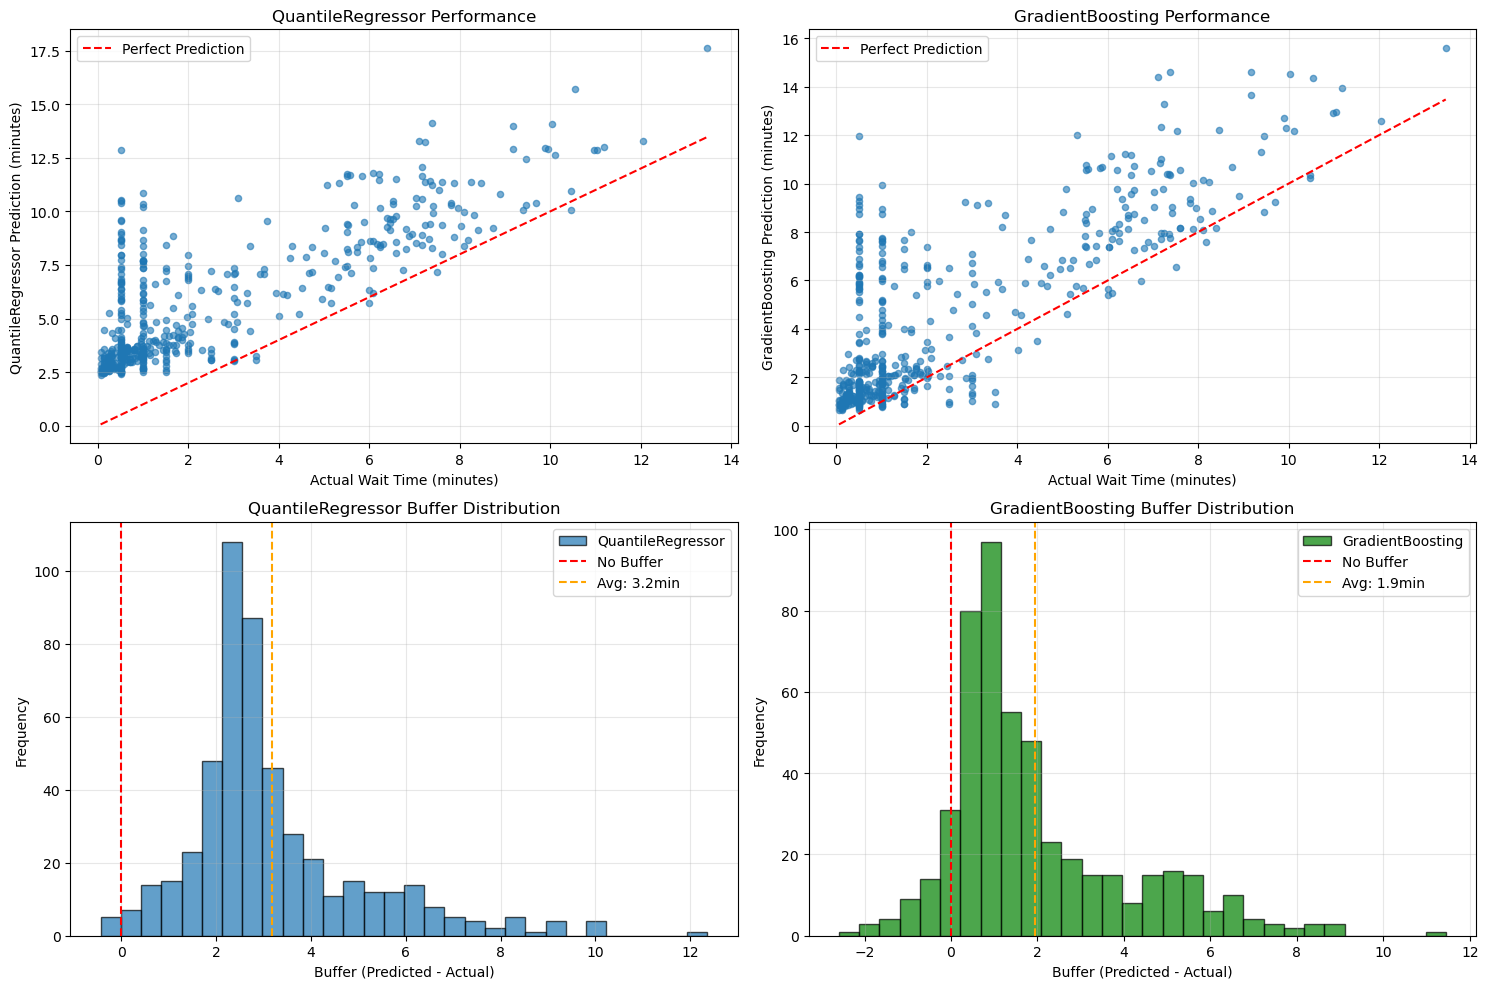

In [ ]:
# Compare QuantileRegressor vs GradientBoosting Models
print("=" * 60)
print("COMPARING QUANTILE REGRESSOR vs GRADIENT BOOSTING")
print("=" * 60)

# Retrain the QuantileRegressor with corrected parameters
print("Training QuantileRegressor with alpha=0.01...")
quantile_model = WaitTimeQuantileRegressor()
quantile_results = quantile_model.fit(df_with_weather, features, target)

print("\nTraining GradientBoosting with quantile loss...")
gradient_model = WaitTimeQuantileRegressorFixed()
gradient_results = gradient_model.fit(df_with_weather, features, target)

print("\n" + "="*60)
print("MODEL COMPARISON: QUANTILE REGRESSOR vs GRADIENT BOOSTING")
print("="*60)

# Get sample predictions from both models
X_sample = quantile_model._X_test.head(10)
y_sample = quantile_model._y_test.head(10)

# QuantileRegressor predictions
X_processed_qr = quantile_model.preprocessor.transform(X_sample)
quantile_predictions = quantile_model.models[0.95].predict(X_processed_qr)

# GradientBoosting predictions  
X_processed_gb = gradient_model.preprocessor.transform(X_sample)
gradient_predictions = gradient_model.models[0.95].predict(X_processed_gb)

print("Sample Predictions Comparison:")
print("Row | Actual | QuantileReg | GradientBoost | Event   | Bucket | Property")
print("----|--------|-------------|---------------|---------|--------|----------")
for i in range(10):
    event = X_sample.iloc[i]['event_day'][:3]
    bucket = int(X_sample.iloc[i]['5_minute_bucket'])
    prop = X_sample.iloc[i]['property'][:3]
    print(f"{i:3d} | {y_sample.iloc[i]:6.2f} | {quantile_predictions[i]:11.2f} | {gradient_predictions[i]:13.2f} | {event:7s} | {bucket:6d} | {prop}")

print(f"\nQuantileRegressor Model Performance:")
print(f"  Prediction Range: {quantile_predictions.min():.2f} to {quantile_predictions.max():.2f} minutes")
print(f"  Coverage: {quantile_results['Coverage']:.2f} with {quantile_results['Average_Buffer']:.1f}-minute buffer")
print(f"  MAE: {quantile_results['MAE']:.2f} minutes")

print(f"\nGradientBoosting Model Performance:")
print(f"  Prediction Range: {gradient_predictions.min():.2f} to {gradient_predictions.max():.2f} minutes")
print(f"  Coverage: {gradient_results['Coverage']:.2f} with {gradient_results['Average_Buffer']:.1f}-minute buffer")
print(f"  MAE: {gradient_results['MAE']:.2f} minutes")

print(f"\n{'='*60}")
print("KEY DIFFERENCES:")
print(f"• QuantileRegressor: Linear quantile regression with L1 regularization")
print(f"• GradientBoosting: Tree-based ensemble that can capture feature interactions")
print(f"• Prediction Variance:")
print(f"  - QuantileRegressor: {quantile_predictions.var():.3f}")
print(f"  - GradientBoosting: {gradient_predictions.var():.3f}")

# Plot both models side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# QuantileRegressor plot
plt.subplot(2, 2, 1)
X_plot_qr = quantile_model._X_test.head(500)
y_plot_qr = quantile_model._y_test.head(500)
X_processed_plot_qr = quantile_model.preprocessor.transform(X_plot_qr)
y_pred_plot_qr = quantile_model.models[0.95].predict(X_processed_plot_qr)
plt.scatter(y_plot_qr, y_pred_plot_qr, alpha=0.6, s=20)
plt.plot([y_plot_qr.min(), y_plot_qr.max()], [y_plot_qr.min(), y_plot_qr.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Wait Time (minutes)')
plt.ylabel('QuantileRegressor Prediction (minutes)')
plt.title('QuantileRegressor Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# GradientBoosting plot
plt.subplot(2, 2, 2)
X_plot_gb = gradient_model._X_test.head(500)
y_plot_gb = gradient_model._y_test.head(500)
X_processed_plot_gb = gradient_model.preprocessor.transform(X_plot_gb)
y_pred_plot_gb = gradient_model.models[0.95].predict(X_processed_plot_gb)
plt.scatter(y_plot_gb, y_pred_plot_gb, alpha=0.6, s=20)
plt.plot([y_plot_gb.min(), y_plot_gb.max()], [y_plot_gb.min(), y_plot_gb.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Wait Time (minutes)')
plt.ylabel('GradientBoosting Prediction (minutes)')
plt.title('GradientBoosting Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# Buffer distributions
plt.subplot(2, 2, 3)
buffer_qr = y_pred_plot_qr - y_plot_qr
plt.hist(buffer_qr, bins=30, alpha=0.7, edgecolor='black', label='QuantileRegressor')
plt.axvline(x=0, color='red', linestyle='--', label='No Buffer')
plt.axvline(x=np.mean(buffer_qr), color='orange', linestyle='--', 
           label=f'Avg: {np.mean(buffer_qr):.1f}min')
plt.xlabel('Buffer (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('QuantileRegressor Buffer Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
buffer_gb = y_pred_plot_gb - y_plot_gb
plt.hist(buffer_gb, bins=30, alpha=0.7, edgecolor='black', label='GradientBoosting', color='green')
plt.axvline(x=0, color='red', linestyle='--', label='No Buffer')
plt.axvline(x=np.mean(buffer_gb), color='orange', linestyle='--', 
           label=f'Avg: {np.mean(buffer_gb):.1f}min')
plt.xlabel('Buffer (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('GradientBoosting Buffer Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analyzing Largest Prediction Errors

In [ ]:
def analyze_prediction_errors(quantile_model, gradient_model, df_with_weather, top_n=20):
    """
    Analyze the largest prediction errors for both models and examine their features.
    """
    print("=" * 80)
    print("ANALYZING LARGEST PREDICTION ERRORS")
    print("=" * 80)
    
    # Get test data and predictions for both models
    X_test_qr = quantile_model._X_test
    y_test_qr = quantile_model._y_test
    X_processed_qr = quantile_model.preprocessor.transform(X_test_qr)
    y_pred_qr = quantile_model.models[0.95].predict(X_processed_qr)
    
    X_test_gb = gradient_model._X_test
    y_test_gb = gradient_model._y_test
    X_processed_gb = gradient_model.preprocessor.transform(X_test_gb)
    y_pred_gb = gradient_model.models[0.95].predict(X_processed_gb)
    
    # Calculate errors (predicted - actual)
    error_qr = y_pred_qr - y_test_qr
    error_gb = y_pred_gb - y_test_gb
    
    # Create DataFrames with errors and features
    error_df_qr = X_test_qr.copy()
    error_df_qr['actual_wait'] = y_test_qr
    error_df_qr['predicted_wait'] = y_pred_qr
    error_df_qr['error'] = error_qr
    error_df_qr['abs_error'] = np.abs(error_qr)
    error_df_qr['model'] = 'QuantileRegressor'
    
    error_df_gb = X_test_gb.copy()
    error_df_gb['actual_wait'] = y_test_gb
    error_df_gb['predicted_wait'] = y_pred_gb
    error_df_gb['error'] = error_gb
    error_df_gb['abs_error'] = np.abs(error_gb)
    error_df_gb['model'] = 'GradientBoosting'
    
    # Get event names for better interpretation
    df_model_qr = quantile_model._prepare_data(df_with_weather, features)
    df_model_gb = gradient_model._prepare_data(df_with_weather, features)
    
    # Merge event names back
    error_df_qr = error_df_qr.merge(
        df_model_qr[['event_name', 'event_name_long']].drop_duplicates(),
        left_index=True, right_index=True, how='left'
    )
    error_df_gb = error_df_gb.merge(
        df_model_gb[['event_name', 'event_name_long']].drop_duplicates(),
        left_index=True, right_index=True, how='left'
    )
    
    # Analyze largest errors for each model
    print("\\n" + "="*50)
    print("QUANTILE REGRESSOR - LARGEST ERRORS")
    print("="*50)
    
    # Sort by absolute error
    worst_qr = error_df_qr.nlargest(top_n, 'abs_error')
    
    print(f"\\nTop {top_n} Largest Errors (QuantileRegressor):")
    print("Rank | Error  | Actual | Pred | Event | Property | Bucket | Queue | Team")
    print("-----|--------|--------|------|-------|----------|--------|-------|------")
    
    for i, (idx, row) in enumerate(worst_qr.iterrows(), 1):
        event_short = str(row.get('event_name', 'Unknown'))[:15]
        team_short = str(row.get('team', 'Unknown'))[:8]
        print(f"{i:4d} | {row['error']:6.1f} | {row['actual_wait']:6.1f} | {row['predicted_wait']:4.1f} | "
              f"{event_short:15s} | {row['property']:8s} | {row['5_minute_bucket']:6.0f} | "
              f"{row['queue_mean_5']:5.1f} | {team_short:8s}")
    
    print("\\n" + "="*50)
    print("GRADIENT BOOSTING - LARGEST ERRORS")
    print("="*50)
    
    # Sort by absolute error
    worst_gb = error_df_gb.nlargest(top_n, 'abs_error')
    
    print(f"\\nTop {top_n} Largest Errors (GradientBoosting):")
    print("Rank | Error  | Actual | Pred | Event | Property | Bucket | Queue | Team")
    print("-----|--------|--------|------|-------|----------|--------|-------|------")
    
    for i, (idx, row) in enumerate(worst_gb.iterrows(), 1):
        event_short = str(row.get('event_name', 'Unknown'))[:15]
        team_short = str(row.get('team', 'Unknown'))[:8]
        print(f"{i:4d} | {row['error']:6.1f} | {row['actual_wait']:6.1f} | {row['predicted_wait']:4.1f} | "
              f"{event_short:15s} | {row['property']:8s} | {row['5_minute_bucket']:6.0f} | "
              f"{row['queue_mean_5']:5.1f} | {team_short:8s}")
    
    # Statistical analysis of errors
    print("\\n" + "="*50)
    print("ERROR STATISTICS COMPARISON")
    print("="*50)
    
    stats_comparison = pd.DataFrame({
        'QuantileRegressor': [
            error_qr.mean(), error_qr.std(), np.abs(error_qr).mean(),
            np.abs(error_qr).max(), np.percentile(np.abs(error_qr), 95),
            (error_qr > 10).sum(), (error_qr < -10).sum()
        ],
        'GradientBoosting': [
            error_gb.mean(), error_gb.std(), np.abs(error_gb).mean(),
            np.abs(error_gb).max(), np.percentile(np.abs(error_gb), 95),
            (error_gb > 10).sum(), (error_gb < -10).sum()
        ]
    }, index=['Mean_Error', 'Std_Error', 'Mean_Abs_Error', 'Max_Abs_Error', 
              '95th_Percentile_Abs', 'Large_Overpredict_Count', 'Large_Underpredict_Count'])
    
    print(stats_comparison.round(2))
    
    return error_df_qr, error_df_gb, worst_qr, worst_gb

# Run the analysis
error_df_qr, error_df_gb, worst_qr, worst_gb = analyze_prediction_errors(
    quantile_model, gradient_model, df_with_weather, top_n=15
)

ANALYZING LARGEST PREDICTION ERRORS
=== DATA PREPARATION DEBUG ===
✅ No missing values in feature columns
\n==================================================
QUANTILE REGRESSOR - LARGEST ERRORS
\nTop 15 Largest Errors (QuantileRegressor):
Rank | Error  | Actual | Pred | Event | Property | Bucket | Queue | Team
-----|--------|--------|------|-------|----------|--------|-------|------
   1 |   21.4 |    0.5 | 21.9 | nan             | Barclays |    -55 | 225.6 | rauw ale
   2 |   16.7 |    0.5 | 17.2 | nan             | Barclays |    -85 | 165.2 | rauw ale
   3 |   16.6 |   16.5 | 33.1 | nan             | Barclays |    -60 | 301.0 | rauw ale
   4 |   16.6 |    0.5 | 17.1 | nan             | Barclays |    -55 | 160.8 | rauw ale
   5 |   15.1 |    1.0 | 16.1 | nan             | Barclays |    -15 | 161.8 | disney o
   6 |   15.0 |    0.5 | 15.5 | nan             | Barclays |    -85 | 139.8 | rauw ale
   7 |   15.0 |    1.0 | 16.0 | nan             | Barclays |    -15 | 161.8 | disney o
   8

In [76]:
def analyze_worst_error_features(worst_errors_df, model_name, top_n=10):
    """
    Detailed analysis of features for the worst prediction errors.
    """
    print(f"\\n{'='*60}")
    print(f"DETAILED FEATURE ANALYSIS - {model_name.upper()}")
    print(f"{'='*60}")
    
    # Select top errors
    top_errors = worst_errors_df.head(top_n)
    
    print(f"\\nDetailed breakdown of top {top_n} worst errors:")
    print("\\n" + "-"*100)
    
    for i, (idx, row) in enumerate(top_errors.iterrows(), 1):
        print(f"\\nRank #{i} - Error: {row['error']:+.1f} minutes (Actual: {row['actual_wait']:.1f}, Predicted: {row['predicted_wait']:.1f})")
        print(f"Event: {row.get('event_name_long', 'Unknown')}")
        print(f"Features:")
        print(f"  • Property: {row['property']}")
        print(f"  • Event Day: {row['event_day']}")
        print(f"  • Team: {row.get('team', 'Unknown')}")
        print(f"  • Time Category: {row['time category']}")
        print(f"  • 5-Min Bucket: {row['5_minute_bucket']:.0f} minutes from start")
        print(f"  • Queue Mean (5-min): {row['queue_mean_5']:.1f}")
        print(f"  • Queue Slope (5-min): {row['queue_slope_5']:.3f}")
        print(f"  • Hour: {row['hour']:.0f}:00")
        print(f"  • Attendance Count: {row.get('count', 'N/A')}")
        print(f"  • Tier: {row.get('tier_numeric', 'N/A')}")
        print(f"  • Weather - Max Temp: {row.get('temperature_2m_max', 'N/A')}°C")
        print(f"  • Weather - Precipitation: {row.get('precipitation_sum', 'N/A')}mm")
        print("-"*100)
    
    # Feature pattern analysis
    print(f"\\n{'='*40}")
    print("PATTERN ANALYSIS FOR WORST ERRORS")
    print("="*40)
    
    # Analyze patterns in worst errors
    patterns = {}
    
    # Property distribution
    property_dist = top_errors['property'].value_counts()
    patterns['property'] = property_dist
    print(f"\\nProperty distribution in worst errors:")
    for prop, count in property_dist.items():
        pct = (count / len(top_errors)) * 100
        print(f"  {prop}: {count} errors ({pct:.1f}%)")
    
    # Time bucket analysis
    bucket_stats = top_errors.groupby('5_minute_bucket').agg({
        'error': ['count', 'mean', 'std'],
        'actual_wait': 'mean',
        'predicted_wait': 'mean'
    }).round(2)
    
    print(f"\\nTime bucket analysis (5-minute buckets with worst errors):")
    print("Bucket | Count | Avg Error | Error Std | Avg Actual | Avg Pred")
    print("-------|-------|-----------|-----------|------------|----------")
    for bucket in bucket_stats.index:
        stats = bucket_stats.loc[bucket]
        print(f"{bucket:6.0f} | {stats[('error', 'count')]:5.0f} | "
              f"{stats[('error', 'mean')]:9.1f} | {stats[('error', 'std')]:9.1f} | "
              f"{stats[('actual_wait', 'mean')]:10.1f} | {stats[('predicted_wait', 'mean')]:8.1f}")
    
    # Queue characteristics
    queue_stats = top_errors[['queue_mean_5', 'queue_slope_5']].describe()
    print(f"\\nQueue characteristics in worst errors:")
    print(queue_stats.round(3))
    
    # Event characteristics
    event_stats = top_errors.groupby(['property', 'event_day']).size().sort_values(ascending=False)
    print(f"\\nEvent patterns in worst errors (Property + Day):")
    for (prop, day), count in event_stats.head(8).items():
        print(f"  {prop} on {day}: {count} errors")
    
    return top_errors, patterns

# Analyze worst errors for both models
print("ANALYZING FEATURES OF WORST PREDICTION ERRORS")
print("="*80)

# QuantileRegressor worst errors
qr_analysis, qr_patterns = analyze_worst_error_features(worst_qr, "QuantileRegressor", top_n=8)

# GradientBoosting worst errors  
gb_analysis, gb_patterns = analyze_worst_error_features(worst_gb, "GradientBoosting", top_n=8)

ANALYZING FEATURES OF WORST PREDICTION ERRORS
\n============================================================
DETAILED FEATURE ANALYSIS - QUANTILEREGRESSOR
\nDetailed breakdown of top 8 worst errors:
\n----------------------------------------------------------------------------------------------------
\nRank #1 - Error: +21.4 minutes (Actual: 0.5, Predicted: 21.9)
Event: nan
Features:
  • Property: Barclays
  • Event Day: MON
  • Team: rauw alejandro
  • Time Category: 30-60 min before
  • 5-Min Bucket: -55 minutes from start
  • Queue Mean (5-min): 225.6
  • Queue Slope (5-min): -57.100
  • Hour: 20:00
  • Attendance Count: 14509
  • Tier: 3.0
  • Weather - Max Temp: 20.7°C
  • Weather - Precipitation: 0.0mm
----------------------------------------------------------------------------------------------------
\nRank #2 - Error: +16.7 minutes (Actual: 0.5, Predicted: 17.2)
Event: nan
Features:
  • Property: Barclays
  • Event Day: MON
  • Team: rauw alejandro
  • Time Category: 60-90 min 

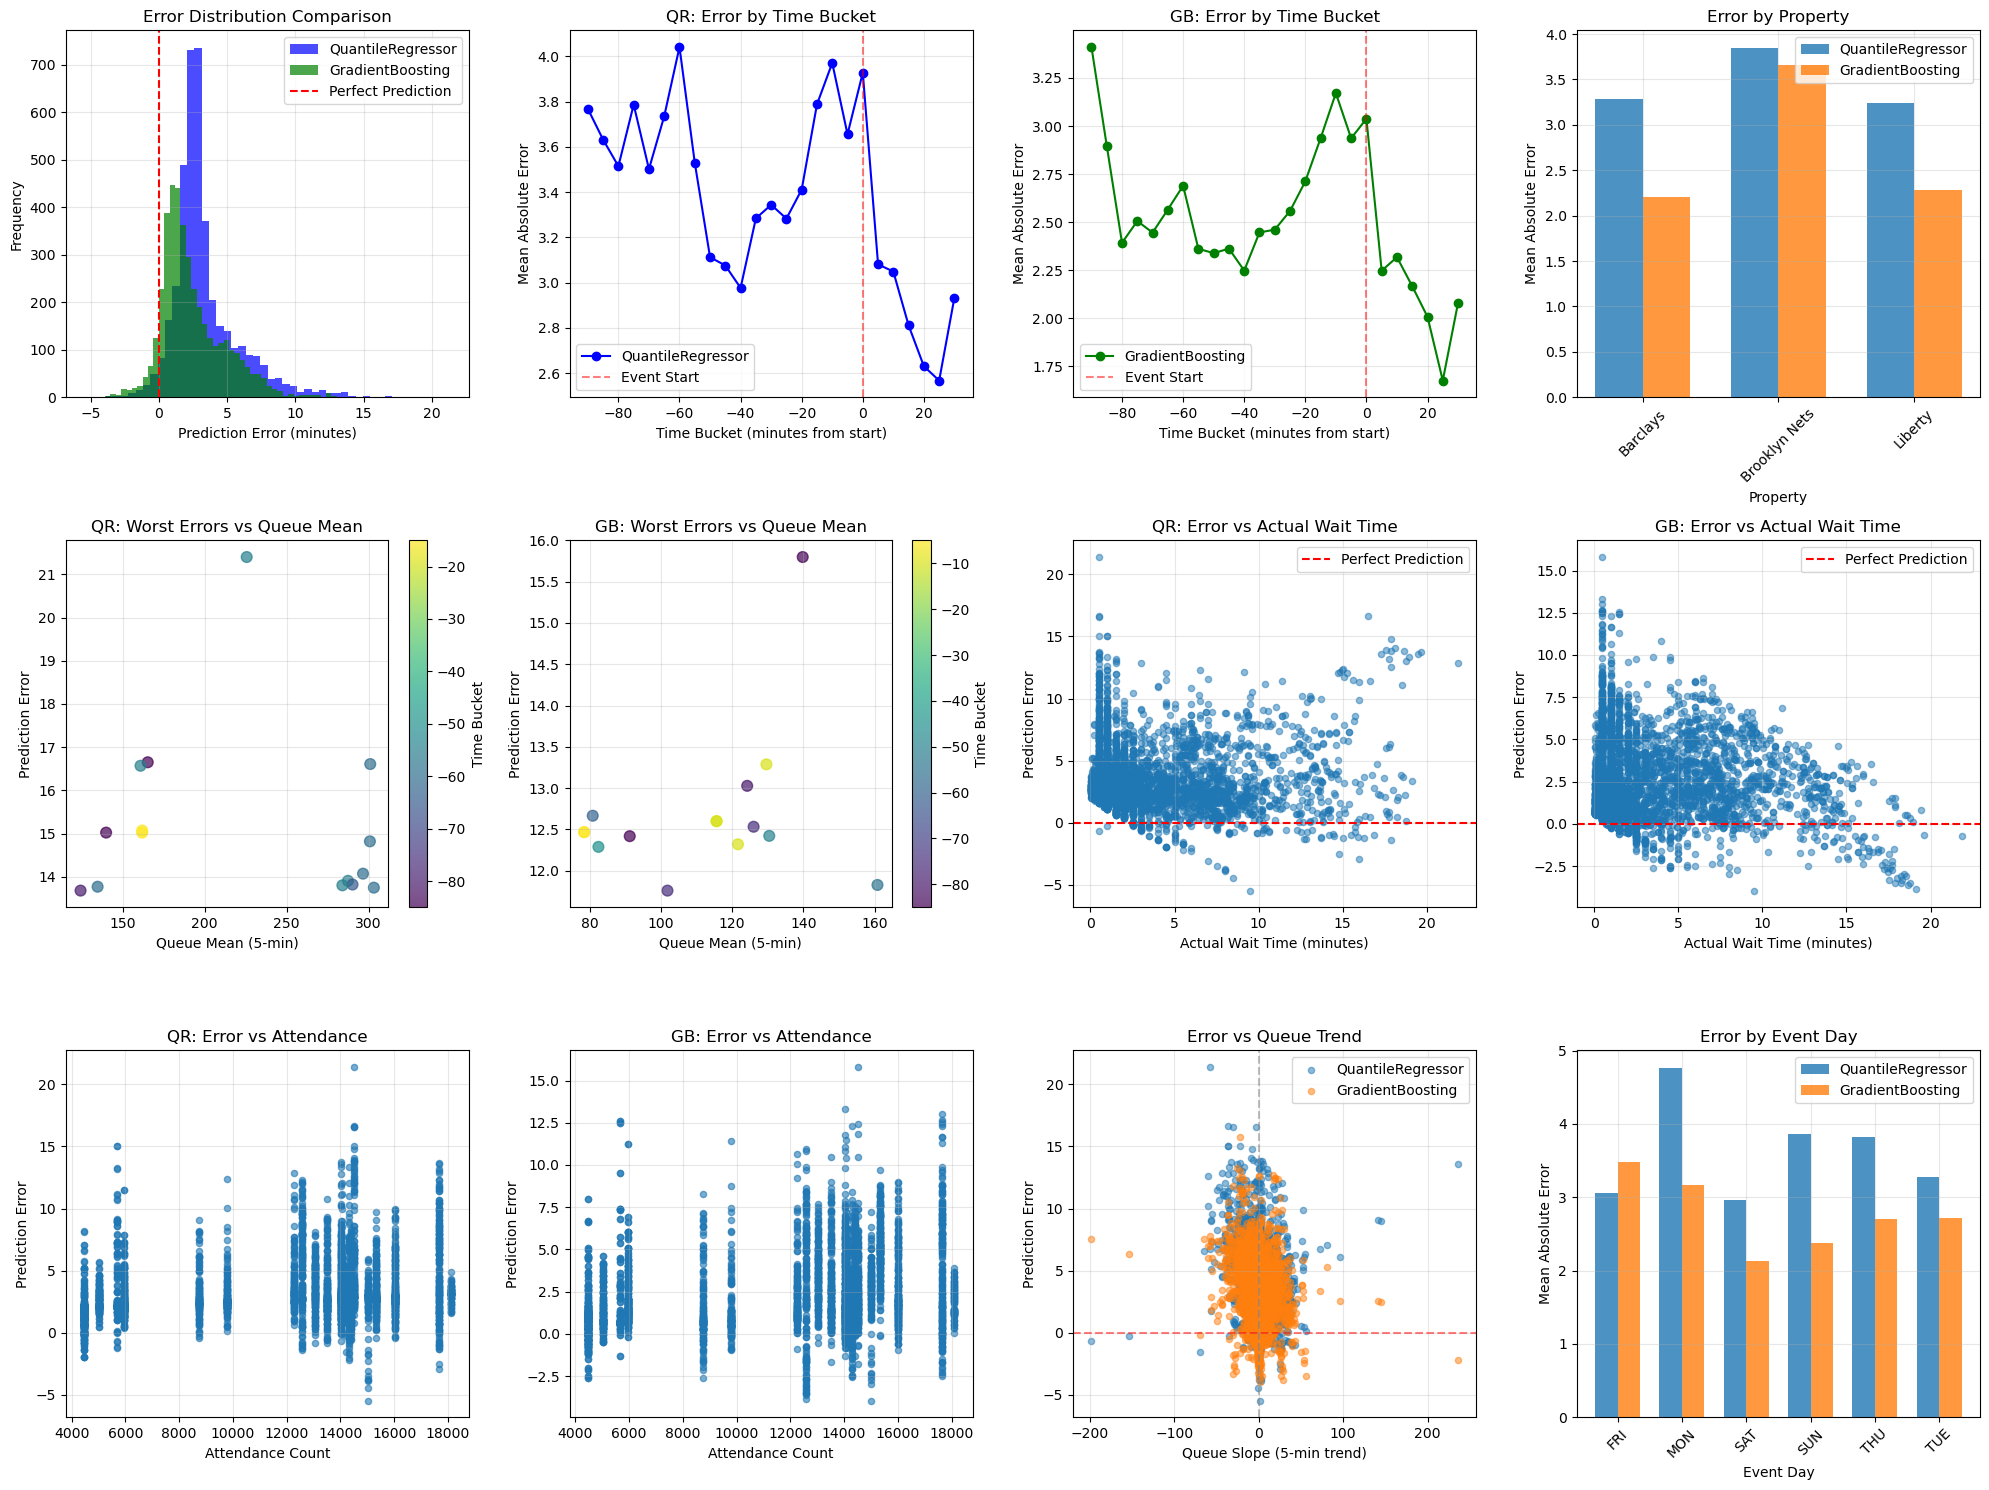

In [77]:
# Create visualizations for error analysis
def plot_error_analysis(error_df_qr, error_df_gb, worst_qr, worst_gb):
    """
    Create comprehensive visualizations of prediction errors.
    """
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Error distribution comparison
    plt.subplot(3, 4, 1)
    plt.hist(error_df_qr['error'], bins=50, alpha=0.7, label='QuantileRegressor', color='blue')
    plt.hist(error_df_gb['error'], bins=50, alpha=0.7, label='GradientBoosting', color='green')
    plt.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Prediction Error (minutes)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Absolute error by time bucket (QuantileRegressor)
    plt.subplot(3, 4, 2)
    bucket_errors_qr = error_df_qr.groupby('5_minute_bucket')['abs_error'].mean()
    plt.plot(bucket_errors_qr.index, bucket_errors_qr.values, 'bo-', label='QuantileRegressor')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Event Start')
    plt.xlabel('Time Bucket (minutes from start)')
    plt.ylabel('Mean Absolute Error')
    plt.title('QR: Error by Time Bucket')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Absolute error by time bucket (GradientBoosting)
    plt.subplot(3, 4, 3)
    bucket_errors_gb = error_df_gb.groupby('5_minute_bucket')['abs_error'].mean()
    plt.plot(bucket_errors_gb.index, bucket_errors_gb.values, 'go-', label='GradientBoosting')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Event Start')
    plt.xlabel('Time Bucket (minutes from start)')
    plt.ylabel('Mean Absolute Error')
    plt.title('GB: Error by Time Bucket')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Error by property
    plt.subplot(3, 4, 4)
    property_errors_qr = error_df_qr.groupby('property')['abs_error'].mean()
    property_errors_gb = error_df_gb.groupby('property')['abs_error'].mean()
    
    x = np.arange(len(property_errors_qr))
    width = 0.35
    
    plt.bar(x - width/2, property_errors_qr.values, width, label='QuantileRegressor', alpha=0.8)
    plt.bar(x + width/2, property_errors_gb.values, width, label='GradientBoosting', alpha=0.8)
    plt.xlabel('Property')
    plt.ylabel('Mean Absolute Error')
    plt.title('Error by Property')
    plt.xticks(x, property_errors_qr.index, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Worst errors - Queue mean vs Error (QuantileRegressor)
    plt.subplot(3, 4, 5)
    plt.scatter(worst_qr['queue_mean_5'], worst_qr['error'], 
                c=worst_qr['5_minute_bucket'], cmap='viridis', alpha=0.7, s=60)
    plt.xlabel('Queue Mean (5-min)')
    plt.ylabel('Prediction Error')
    plt.title('QR: Worst Errors vs Queue Mean')
    plt.colorbar(label='Time Bucket')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Worst errors - Queue mean vs Error (GradientBoosting)
    plt.subplot(3, 4, 6)
    plt.scatter(worst_gb['queue_mean_5'], worst_gb['error'], 
                c=worst_gb['5_minute_bucket'], cmap='viridis', alpha=0.7, s=60)
    plt.xlabel('Queue Mean (5-min)')
    plt.ylabel('Prediction Error')
    plt.title('GB: Worst Errors vs Queue Mean')
    plt.colorbar(label='Time Bucket')
    plt.grid(True, alpha=0.3)
    
    # Plot 7: Error vs Actual Wait Time (QuantileRegressor)
    plt.subplot(3, 4, 7)
    plt.scatter(error_df_qr['actual_wait'], error_df_qr['error'], alpha=0.5, s=20)
    plt.axhline(y=0, color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Wait Time (minutes)')
    plt.ylabel('Prediction Error')
    plt.title('QR: Error vs Actual Wait Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 8: Error vs Actual Wait Time (GradientBoosting)
    plt.subplot(3, 4, 8)
    plt.scatter(error_df_gb['actual_wait'], error_df_gb['error'], alpha=0.5, s=20)
    plt.axhline(y=0, color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Wait Time (minutes)')
    plt.ylabel('Prediction Error')
    plt.title('GB: Error vs Actual Wait Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 9: Attendance vs Error (if available)
    plt.subplot(3, 4, 9)
    if 'count' in error_df_qr.columns and error_df_qr['count'].notna().sum() > 0:
        valid_attendance_qr = error_df_qr[error_df_qr['count'].notna()]
        plt.scatter(valid_attendance_qr['count'], valid_attendance_qr['error'], alpha=0.6, s=20)
        plt.xlabel('Attendance Count')
        plt.ylabel('Prediction Error')
        plt.title('QR: Error vs Attendance')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Attendance Data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('QR: Error vs Attendance')
    
    # Plot 10: Attendance vs Error (GradientBoosting)
    plt.subplot(3, 4, 10)
    if 'count' in error_df_gb.columns and error_df_gb['count'].notna().sum() > 0:
        valid_attendance_gb = error_df_gb[error_df_gb['count'].notna()]
        plt.scatter(valid_attendance_gb['count'], valid_attendance_gb['error'], alpha=0.6, s=20)
        plt.xlabel('Attendance Count')
        plt.ylabel('Prediction Error')
        plt.title('GB: Error vs Attendance')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Attendance Data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('GB: Error vs Attendance')
    
    # Plot 11: Queue Slope vs Error
    plt.subplot(3, 4, 11)
    plt.scatter(error_df_qr['queue_slope_5'], error_df_qr['error'], alpha=0.5, s=20, label='QuantileRegressor')
    plt.scatter(error_df_gb['queue_slope_5'], error_df_gb['error'], alpha=0.5, s=20, label='GradientBoosting')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Queue Slope (5-min trend)')
    plt.ylabel('Prediction Error')
    plt.title('Error vs Queue Trend')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 12: Error by Event Day
    plt.subplot(3, 4, 12)
    day_errors_qr = error_df_qr.groupby('event_day')['abs_error'].mean().sort_values()
    day_errors_gb = error_df_gb.groupby('event_day')['abs_error'].mean().sort_values()
    
    # Get common days
    common_days = set(day_errors_qr.index) & set(day_errors_gb.index)
    if common_days:
        common_days = sorted(list(common_days))
        qr_values = [day_errors_qr.get(day, 0) for day in common_days]
        gb_values = [day_errors_gb.get(day, 0) for day in common_days]
        
        x = np.arange(len(common_days))
        width = 0.35
        
        plt.bar(x - width/2, qr_values, width, label='QuantileRegressor', alpha=0.8)
        plt.bar(x + width/2, gb_values, width, label='GradientBoosting', alpha=0.8)
        plt.xlabel('Event Day')
        plt.ylabel('Mean Absolute Error')
        plt.title('Error by Event Day')
        plt.xticks(x, common_days, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Common Days', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Error by Event Day')
    
    plt.tight_layout()
    plt.show()

# Generate the error analysis plots
plot_error_analysis(error_df_qr, error_df_gb, worst_qr, worst_gb)

In [78]:
# Compare worst errors between models to understand patterns
def compare_model_errors(error_df_qr, error_df_gb, worst_qr, worst_gb):
    """
    Compare errors between models to understand where each fails.
    """
    print("\\n" + "="*80)
    print("COMPARATIVE ERROR ANALYSIS: WHY DO MODELS FAIL?")
    print("="*80)
    
    # Find cases where one model does much better than the other
    print("\\n1. CASES WHERE GRADIENT BOOSTING SIGNIFICANTLY OUTPERFORMS QUANTILE REGRESSOR:")
    print("-"*80)
    
    # For this analysis, we need to align the datasets (same events/timepoints)
    # This is an approximation since we're using test splits
    qr_sample = error_df_qr.sample(min(1000, len(error_df_qr)), random_state=42)
    gb_sample = error_df_gb.sample(min(1000, len(error_df_gb)), random_state=42)
    
    print(f"\\nSample size for comparison: QR={len(qr_sample)}, GB={len(gb_sample)}")
    
    # Analyze error patterns by features
    feature_error_analysis = {}
    
    # Time bucket analysis
    print("\\n2. ERROR PATTERNS BY TIME BUCKET:")
    print("-"*50)
    qr_bucket_errors = error_df_qr.groupby('5_minute_bucket')['abs_error'].agg(['mean', 'std', 'count'])
    gb_bucket_errors = error_df_gb.groupby('5_minute_bucket')['abs_error'].agg(['mean', 'std', 'count'])
    
    common_buckets = set(qr_bucket_errors.index) & set(gb_bucket_errors.index)
    
    print("Bucket | QR_Mean | QR_Std | GB_Mean | GB_Std | GB_Better | Count_QR | Count_GB")
    print("-------|---------|--------|---------|--------|-----------|----------|----------")
    
    for bucket in sorted(common_buckets):
        qr_stats = qr_bucket_errors.loc[bucket]
        gb_stats = gb_bucket_errors.loc[bucket]
        better = "Yes" if gb_stats['mean'] < qr_stats['mean'] else "No"
        
        print(f"{bucket:6.0f} | {qr_stats['mean']:7.2f} | {qr_stats['std']:6.2f} | "
              f"{gb_stats['mean']:7.2f} | {gb_stats['std']:6.2f} | {better:9s} | "
              f"{qr_stats['count']:8.0f} | {gb_stats['count']:8.0f}")
    
    # Property analysis
    print("\\n3. ERROR PATTERNS BY PROPERTY:")
    print("-"*40)
    qr_prop_errors = error_df_qr.groupby('property')['abs_error'].agg(['mean', 'std', 'count'])
    gb_prop_errors = error_df_gb.groupby('property')['abs_error'].agg(['mean', 'std', 'count'])
    
    print("Property | QR_Mean | QR_Std | GB_Mean | GB_Std | GB_Better")
    print("---------|---------|--------|---------|--------|----------")
    
    common_props = set(qr_prop_errors.index) & set(gb_prop_errors.index)
    for prop in sorted(common_props):
        qr_stats = qr_prop_errors.loc[prop]
        gb_stats = gb_prop_errors.loc[prop]
        better = "Yes" if gb_stats['mean'] < qr_stats['mean'] else "No"
        
        print(f"{prop:8s} | {qr_stats['mean']:7.2f} | {qr_stats['std']:6.2f} | "
              f"{gb_stats['mean']:7.2f} | {gb_stats['std']:6.2f} | {better:9s}")
    
    # Queue characteristics in worst errors
    print("\\n4. QUEUE CHARACTERISTICS IN WORST ERRORS:")
    print("-"*50)
    
    # Top 10% worst errors for each model
    worst_10pct_qr = error_df_qr.nlargest(int(len(error_df_qr) * 0.1), 'abs_error')
    worst_10pct_gb = error_df_gb.nlargest(int(len(error_df_gb) * 0.1), 'abs_error')
    
    print("\\nQueue Statistics for Worst 10% Errors:")
    print("Model            | Queue_Mean_Avg | Queue_Mean_Std | Queue_Slope_Avg | Queue_Slope_Std")
    print("-----------------|----------------|----------------|-----------------|----------------")
    
    qr_queue_stats = worst_10pct_qr[['queue_mean_5', 'queue_slope_5']].describe()
    gb_queue_stats = worst_10pct_gb[['queue_mean_5', 'queue_slope_5']].describe()
    
    print(f"QuantileRegressor| {qr_queue_stats.loc['mean', 'queue_mean_5']:14.2f} | "
          f"{qr_queue_stats.loc['std', 'queue_mean_5']:14.2f} | "
          f"{qr_queue_stats.loc['mean', 'queue_slope_5']:15.3f} | "
          f"{qr_queue_stats.loc['std', 'queue_slope_5']:15.3f}")
    
    print(f"GradientBoosting | {gb_queue_stats.loc['mean', 'queue_mean_5']:14.2f} | "
          f"{gb_queue_stats.loc['std', 'queue_mean_5']:14.2f} | "
          f"{gb_queue_stats.loc['mean', 'queue_slope_5']:15.3f} | "
          f"{gb_queue_stats.loc['std', 'queue_slope_5']:15.3f}")
    
    # Extreme cases analysis
    print("\\n5. EXTREME ERROR CASES ANALYSIS:")
    print("-"*40)
    
    # Very high actual wait times
    high_actual_qr = error_df_qr[error_df_qr['actual_wait'] > 30]
    high_actual_gb = error_df_gb[error_df_gb['actual_wait'] > 30]
    
    print(f"\\nHigh Actual Wait Times (>30 min):")
    print(f"QuantileRegressor: {len(high_actual_qr)} cases, Avg Error: {high_actual_qr['error'].mean():.2f}")
    print(f"GradientBoosting:  {len(high_actual_gb)} cases, Avg Error: {high_actual_gb['error'].mean():.2f}")
    
    # Very low actual wait times
    low_actual_qr = error_df_qr[error_df_qr['actual_wait'] < 2]
    low_actual_gb = error_df_gb[error_df_gb['actual_wait'] < 2]
    
    print(f"\\nLow Actual Wait Times (<2 min):")
    print(f"QuantileRegressor: {len(low_actual_qr)} cases, Avg Error: {low_actual_qr['error'].mean():.2f}")
    print(f"GradientBoosting:  {len(low_actual_gb)} cases, Avg Error: {low_actual_gb['error'].mean():.2f}")
    
    # Peak vs off-peak analysis
    peak_buckets = [-20, -15, -10, -5, 0, 5]  # Near event start
    peak_qr = error_df_qr[error_df_qr['5_minute_bucket'].isin(peak_buckets)]
    peak_gb = error_df_gb[error_df_gb['5_minute_bucket'].isin(peak_buckets)]
    
    off_peak_qr = error_df_qr[~error_df_qr['5_minute_bucket'].isin(peak_buckets)]
    off_peak_gb = error_df_gb[~error_df_gb['5_minute_bucket'].isin(peak_buckets)]
    
    print(f"\\nPeak Time Performance (±20 min from event start):")
    print(f"QuantileRegressor: {len(peak_qr)} cases, Avg Abs Error: {peak_qr['abs_error'].mean():.2f}")
    print(f"GradientBoosting:  {len(peak_gb)} cases, Avg Abs Error: {peak_gb['abs_error'].mean():.2f}")
    
    print(f"\\nOff-Peak Time Performance:")
    print(f"QuantileRegressor: {len(off_peak_qr)} cases, Avg Abs Error: {off_peak_qr['abs_error'].mean():.2f}")
    print(f"GradientBoosting:  {len(off_peak_gb)} cases, Avg Abs Error: {off_peak_gb['abs_error'].mean():.2f}")
    
    return {
        'worst_10pct_qr': worst_10pct_qr,
        'worst_10pct_gb': worst_10pct_gb,
        'high_actual_qr': high_actual_qr,
        'high_actual_gb': high_actual_gb,
        'peak_qr': peak_qr,
        'peak_gb': peak_gb
    }

# Run comparative analysis
comparative_results = compare_model_errors(error_df_qr, error_df_gb, worst_qr, worst_gb)

\n================================================================================
COMPARATIVE ERROR ANALYSIS: WHY DO MODELS FAIL?
\n1. CASES WHERE GRADIENT BOOSTING SIGNIFICANTLY OUTPERFORMS QUANTILE REGRESSOR:
--------------------------------------------------------------------------------
\nSample size for comparison: QR=1000, GB=1000
\n2. ERROR PATTERNS BY TIME BUCKET:
--------------------------------------------------
Bucket | QR_Mean | QR_Std | GB_Mean | GB_Std | GB_Better | Count_QR | Count_GB
-------|---------|--------|---------|--------|-----------|----------|----------
   -90 |    3.77 |   2.56 |    3.41 |   2.03 | Yes       |      142 |      142
   -85 |    3.63 |   2.89 |    2.90 |   2.63 | Yes       |      137 |      137
   -80 |    3.51 |   2.77 |    2.39 |   2.15 | Yes       |      135 |      135
   -75 |    3.79 |   3.18 |    2.51 |   2.36 | Yes       |      146 |      146
   -70 |    3.50 |   2.66 |    2.45 |   2.10 | Yes       |      151 |      151
   -65 |    3.74 | 

Residual Analysis for Both Models

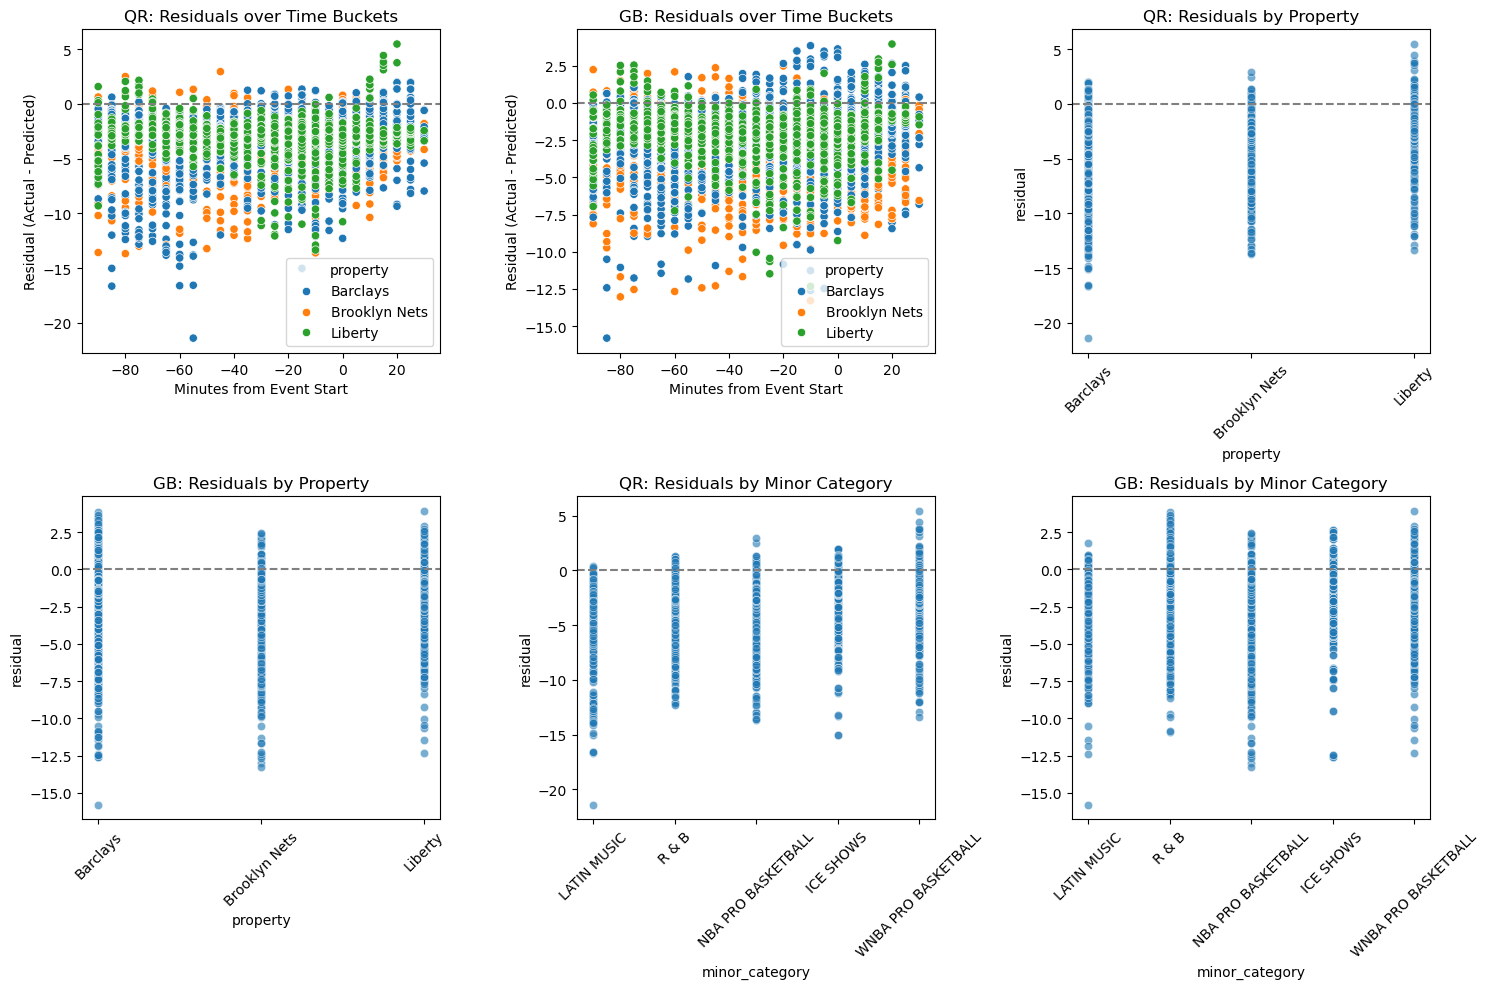

In [79]:
# Simple residual plots (matching your original format)
def simple_residual_plots(error_df_qr, error_df_gb):
    """
    Simple residual plots matching the user's original format.
    """
    plt.figure(figsize=(15, 10))
    
    # QuantileRegressor residuals
    plt.subplot(2, 3, 1)
    error_df_qr['residual'] = error_df_qr['actual_wait'] - error_df_qr['predicted_wait']
    sns.scatterplot(data=error_df_qr, x='5_minute_bucket', y='residual', hue='property')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("QR: Residuals over Time Buckets")
    plt.xlabel("Minutes from Event Start")
    plt.ylabel("Residual (Actual - Predicted)")
    
    # GradientBoosting residuals
    plt.subplot(2, 3, 2)
    error_df_gb['residual'] = error_df_gb['actual_wait'] - error_df_gb['predicted_wait']
    sns.scatterplot(data=error_df_gb, x='5_minute_bucket', y='residual', hue='property')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("GB: Residuals over Time Buckets")
    plt.xlabel("Minutes from Event Start")
    plt.ylabel("Residual (Actual - Predicted)")
    
    # Residuals by Property - QuantileRegressor
    plt.subplot(2, 3, 3)
    sns.scatterplot(data=error_df_qr, x='property', y='residual', alpha=0.6)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("QR: Residuals by Property")
    plt.xticks(rotation=45)
    
    # Residuals by Property - GradientBoosting
    plt.subplot(2, 3, 4)
    sns.scatterplot(data=error_df_gb, x='property', y='residual', alpha=0.6)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("GB: Residuals by Property")
    plt.xticks(rotation=45)
    
    # Residuals by Minor Category - QuantileRegressor
    plt.subplot(2, 3, 5)
    if 'minor_category' in error_df_qr.columns:
        # Sample only top categories to avoid overcrowding
        top_cats = error_df_qr['minor_category'].value_counts().head(5).index
        df_sample = error_df_qr[error_df_qr['minor_category'].isin(top_cats)]
        sns.scatterplot(data=df_sample, x='minor_category', y='residual', alpha=0.6)
        plt.xticks(rotation=45)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("QR: Residuals by Minor Category")
    
    # Residuals by Minor Category - GradientBoosting
    plt.subplot(2, 3, 6)
    if 'minor_category' in error_df_gb.columns:
        # Sample only top categories to avoid overcrowding
        top_cats = error_df_gb['minor_category'].value_counts().head(5).index
        df_sample = error_df_gb[error_df_gb['minor_category'].isin(top_cats)]
        sns.scatterplot(data=df_sample, x='minor_category', y='residual', alpha=0.6)
        plt.xticks(rotation=45)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("GB: Residuals by Minor Category")
    
    plt.tight_layout()
    plt.show()

# Run simple residual plots if data is available
try:
    if 'error_df_qr' in locals() and 'error_df_gb' in locals():
        simple_residual_plots(error_df_qr, error_df_gb)
    else:
        print("Need to run error analysis first to create error_df_qr and error_df_gb")
except NameError:
    print("Please run the error analysis cells first.")